## Libraries imports

In [121]:
import re
import os
import shutil
import logging
import pgeocode 
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
from decimal import Decimal
from shapely.geometry import Point
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam
from tensorflow.keras.models import load_model
import ray
from ray import train, tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.air.integrations.keras import ReportCheckpointCallback
from ray.air.integrations.mlflow import MLflowLoggerCallback
import mlflow

## Reading datasets
### There are 4 datasets to get the biggest amount of data. They are all merged into one big dataset

In [122]:
file_one = "dataset/to_merge/Animal_Shelter_Intake_and_Outcome-6-1-24.csv"
file_two = "dataset/to_merge/Animal_Shelter_Intake_and_Outcome-8-12-23.csv"
file_three = "dataset/to_merge/Animal_Shelter_Intake_and_Outcome-20-6-23.csv"
file_four = "dataset/to_merge/Animal_Shelter_Intake_and_Outcome-7-1-24.csv"

df_one = pd.read_csv(file_one, sep=',')
df_two = pd.read_csv(file_two, sep=',')
df_three = pd.read_csv(file_three, sep=';')
df_four = pd.read_csv(file_four, sep=',')

df = pd.concat([df_one, df_two, df_three, df_four])
df.reset_index(inplace=True, drop=True)

## Data analysis

### Sample of data - 5 first rows

In [123]:
df.head()
df.head().to_csv('files_for_analysis/df_head_pre.csv', index=False)

Name - Name of the animal. Animal names with an asterisk before them were given by shelter staff.<br>
Type - Type of animal<br>
Breed - Breed of animal<br>
Color - Color of animal, Black, Chocolate, White….
<br>Sex - Male, Female, Neutered Male, Spayed Female
<br>Size - Large, medium, small, toy
<br>Date Of Birth - Approximate date of birth.
<br>Impound Number - Animal impound number
<br>Kennel Number - Kennel number indicating its current location.
<br>Animal ID - Unique ID
<br>Intake Date	- Date animal was taken into the shelter
<br>Outcome Date - Date animal left the shelter
<br>Days in Shelter	- Number of days the animal was in the shelter
<br>Intake Type	- Reason for intake
<br>Intake Subtype - Sub reason for intake
<br>Outcome Type - Reason for release from shelter
<br>Outcome Subtype	- Sub reason for release from shelter
<br>Intake Condition - Animals condition at intake
<br>Outcome Condition - Animals condition at release from shelter
<br>Intake Jurisdiction	- Jurisdiction responsible for animal intake
<br>Outcome Jurisdiction - Area animal went to.
<br>Outcome Zip Code - Zip code where animal went to.
<br>Location - Latitude, Longitude coordinates for outcome jurisdiction
<br>Count - Column for performing arithmetic and creating groups for views and visualizations

### Data size

In [124]:
df.shape

(106096, 24)

### Types of data - names of all columns

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106096 entries, 0 to 106095
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Name                  78230 non-null   object 
 1   Type                  106096 non-null  object 
 2   Breed                 106096 non-null  object 
 3   Color                 106096 non-null  object 
 4   Sex                   106096 non-null  object 
 5   Size                  105956 non-null  object 
 6   Date Of Birth         79907 non-null   object 
 7   Impound Number        106096 non-null  object 
 8   Kennel Number         105981 non-null  object 
 9   Animal ID             106096 non-null  object 
 10  Intake Date           106096 non-null  object 
 11  Outcome Date          105170 non-null  object 
 12  Days in Shelter       106096 non-null  object 
 13  Intake Type           106096 non-null  object 
 14  Intake Subtype        106096 non-null  object 
 15  

### Check for null values

In [126]:
df.isnull().sum()

Name                    27866
Type                        0
Breed                       0
Color                       0
Sex                         0
Size                      140
Date Of Birth           26189
Impound Number              0
Kennel Number             115
Animal ID                   0
Intake Date                 0
Outcome Date              926
Days in Shelter             0
Intake Type                 0
Intake Subtype              0
Outcome Type              950
Outcome Subtype          2251
Intake Condition            0
Outcome Condition        2360
Intake Jurisdiction         0
Outcome Jurisdiction    15158
Outcome Zip Code        15317
Location                15317
Count                       0
dtype: int64

## Data preprocessing

#### Check for any "outcome date" null values. If it is null, it means the animal is still in the shelter, so these rows can be deleted, because they won't give any useful information

In [127]:
df[df["Outcome Date"].isnull()]

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
92,*CRINKLE,CAT,DOMESTIC SH,BRN TABBY,Spayed,KITTN,08/21/2023,K23-046612,NaN,A421570,...,FIELD,NaN,NaN,TREATABLE/REHAB,NaN,UNKNOWN,NaN,NaN,NaN,1
96,*PHILLIP,DOG,PIT BULL/MIX,GRAY,Neutered,MED,07/26/2022,K23-045491,FOSTER,A417359,...,OVER THE COUNTER,NaN,NaN,HEALTHY,NaN,SANTA ROSA,COUNTY,95403.0,"95403(38.4716444, -122.7398255)",1
108,NaN,DOG,BORDER COLLIE,TRICOLOR,Male,MED,NaN,K23-046882,DQ114,A422318,...,FLD_CRUEL,NaN,NaN,UNKNOWN,NaN,COUNTY,COUNTY,95476.0,"95476(38.288405, -122.464525)",1
140,KATANA,OTHER,HORSE,BROWN/BLACK,Neutered,X-LRG,05/01/2000,K23-045785,CHANGE,A368074,...,FLD_CRUEL,NaN,NaN,UNKNOWN,NaN,COUNTY,SANTA ROSA,95403.0,"95403(38.4716444, -122.7398255)",1
173,NaN,DOG,PIT BULL/MIX,TAN,Male,SMALL,NaN,K23-046392,DS92,A421054,...,FIELD,NaN,NaN,UNKNOWN,NaN,SANTA ROSA,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95005,*SHELBY,DOG,PIT BULL,WHITE,Spayed,LARGE,07/24/2021,K22-043381,NaN,A414491,...,OVER THE COUNTER,NaN,NaN,HEALTHY,NaN,SANTA ROSA,NaN,NaN,NaN,1
95586,*BONNIE,DOG,PIT BULL,BLACK/WHITE,Spayed,LARGE,02/14/2021,K23-043531,NaN,A414773,...,OVER THE COUNTER,NaN,NaN,UNKNOWN,NaN,SANTA ROSA,NaN,NaN,NaN,1
102658,*IKE,DOG,SIBERIAN HUSKY,BLACK/WHITE,Neutered,LARGE,04/01/2020,K23-044262,DA42,A416471,...,OVER THE COUNTER,NaN,NaN,HEALTHY,NaN,COUNTY,NaN,NaN,NaN,1
103103,*CHUCK,DOG,PIT BULL/MIX,BLACK,Neutered,LARGE,02/05/2013,K15-014582,NaN,A316155,...,FIELD,NaN,NaN,TREATABLE/REHAB,NaN,SANTA ROSA,NaN,NaN,NaN,1


#### There are 926 rows with null Outcome Date, so they can be deleted

In [128]:
df.dropna(subset=["Outcome Date"], inplace=True)

#### Outcome Zip Code contains the same info as Location, so Outcome Zip Code can be removed

In [129]:
df.drop("Outcome Zip Code", axis=1, inplace=True)

#### Date values should be converted to date type objects. Added a new column called "Count days" - it it only for analysis purposes, so it is possible to check if values in the Days in Shelter column are real

In [130]:
df["Outcome Date"] = pd.to_datetime(df["Outcome Date"])
df["Intake Date"] = pd.to_datetime(df["Intake Date"])
df["Count days"] = (df["Outcome Date"] - df["Intake Date"]).dt.days

In [131]:
df["Count days"] = df["Count days"].astype(int)

In [132]:
df[df["Days in Shelter"].astype(str) != df["Count days"].astype(str)][["Days in Shelter", "Count days"]]

,Days in Shelter,Count days
72041,"1,239",1239
97694,"1,239",1239


### All values in days in shelter are correct, only formatting is not the same, so the column "Days in Shelter" will be replaced with data from "Count Days"

In [133]:
df.drop(columns=["Days in Shelter"], inplace=True)
df.rename(columns={"Count days": "Days in Shelter"}, inplace=True)

In [134]:
print(sorted(df["Days in Shelter"].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226,

### Handling duplicates, they do not provide any value to the model

In [135]:
df.duplicated().sum()

56716

### There are 56716, so I will remove them, but keep the first occurence, so I won't loose information

In [136]:
df.drop_duplicates(inplace=True, keep='first')

## Correlation matrix

In [137]:
def show_correlation_matrix_and_days_corr(df):
    encoder = LabelEncoder()
    labeled_df = df.apply(encoder.fit_transform)
    corrmat = labeled_df.corr()
    
    plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, vmax=.8, square=True)
    plt.show()
    print("Correlation values with Days in Shelter:")
    print(corrmat['Days in Shelter'].sort_values(ascending=False))

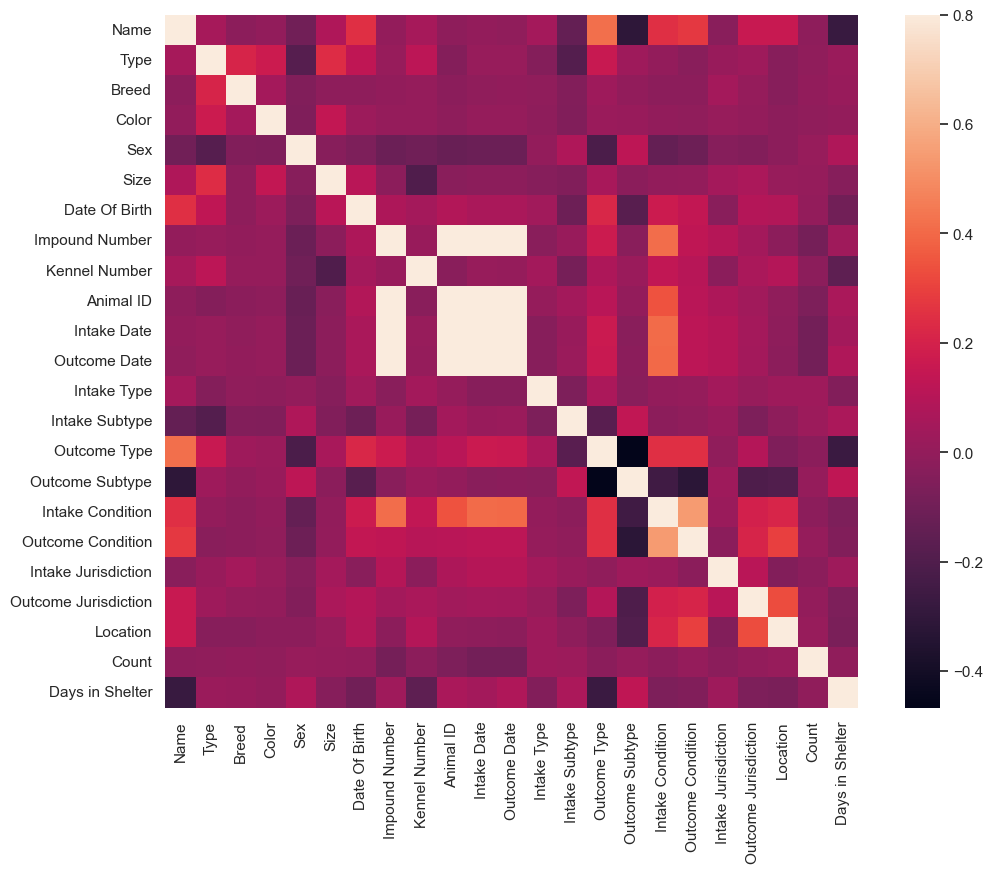

Correlation values with Days in Shelter:
Days in Shelter         1.000000
Outcome Subtype         0.128141
Outcome Date            0.079409
Sex                     0.078123
Intake Subtype          0.071134
Animal ID               0.064356
Intake Date             0.046795
Impound Number          0.037847
Intake Jurisdiction     0.030154
Type                    0.021635
Breed                   0.016245
Color                  -0.000991
Count                  -0.009234
Size                   -0.038279
Intake Type            -0.048577
Outcome Condition      -0.054918
Outcome Jurisdiction   -0.061815
Intake Condition       -0.062111
Location               -0.072609
Date Of Birth          -0.098254
Kennel Number          -0.159936
Outcome Type           -0.272045
Name                   -0.278192
Name: Days in Shelter, dtype: float64


In [138]:
show_correlation_matrix_and_days_corr(df)

## Removing columns that have useless data.

In [139]:
df = df.drop(['Impound Number', 'Animal ID', 'Count'], axis=1)

In [140]:
df[(df["Name"] == "BUDDY") & (df["Breed"] == "SIBERIAN HUSKY/MIX")]

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Kennel Number,Intake Date,Outcome Date,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Location,Days in Shelter
11641,BUDDY,DOG,SIBERIAN HUSKY/MIX,BLACK/WHITE,Neutered,LARGE,NaN,DS67,2015-01-06,2015-01-07,STRAY,OVER THE COUNTER,RETURN TO OWNER,OVER THE COUNTER_WEB,HEALTHY,HEALTHY,COUNTY,OUT OF COUNTY,"99701(64.8413, -147.718335)",1
25259,BUDDY,DOG,SIBERIAN HUSKY/MIX,BLACK/TAN,Male,LARGE,NaN,DS81,2021-12-01,2021-12-01,STRAY,PHONE,RETURN TO OWNER,OVER THE COUNTER_MCHIP,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,"95401(38.44366000000008, -122.72461629999998)",0
56455,BUDDY,DOG,SIBERIAN HUSKY/MIX,BLACK/TAN,Male,LARGE,NaN,DS81,2021-12-01,2021-12-01,STRAY,PHONE,RETURN TO OWNER,OVER THE COUNTER_MCHIP,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,"95401(38.45663, -122.72292)",0
71850,BUDDY,DOG,SIBERIAN HUSKY/MIX,BLACK/WHITE,Neutered,LARGE,NaN,DS67,2015-01-06,2015-01-07,STRAY,OVER THE COUNTER,RETURN TO OWNER,OVER THE COUNTER_WEB,HEALTHY,HEALTHY,COUNTY,OUT OF COUNTY,"99701(64.84527, -147.72213)",1


Some duplicated have different location, I will keep only one value

In [141]:
df.drop_duplicates(subset=df.columns.difference(['Location']), inplace=True, keep='first')

In [142]:
df[(df["Name"] == "BUDDY") & (df["Breed"] == "SIBERIAN HUSKY/MIX")]

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Kennel Number,Intake Date,Outcome Date,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Location,Days in Shelter
11641,BUDDY,DOG,SIBERIAN HUSKY/MIX,BLACK/WHITE,Neutered,LARGE,NaN,DS67,2015-01-06,2015-01-07,STRAY,OVER THE COUNTER,RETURN TO OWNER,OVER THE COUNTER_WEB,HEALTHY,HEALTHY,COUNTY,OUT OF COUNTY,"99701(64.8413, -147.718335)",1
25259,BUDDY,DOG,SIBERIAN HUSKY/MIX,BLACK/TAN,Male,LARGE,NaN,DS81,2021-12-01,2021-12-01,STRAY,PHONE,RETURN TO OWNER,OVER THE COUNTER_MCHIP,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,"95401(38.44366000000008, -122.72461629999998)",0


In [143]:
df.reset_index(inplace=True, drop=True)

## Location map

### Splitting location into latitude and longitude

In [144]:
df["Location"].to_csv("files_for_analysis/location.csv", index=False)

In [145]:
regex_string = r'(\d+)[^\d]+([\d.-]+),\s*([\d.-]+)'
nomi = pgeocode.Nominatim('us') 

latitude = []
longitude = []
zip_code = []

for i in range(len(df)):
    location = str(df['Location'][i])
    if '(' not in location:
        zip_code.append(location)
        result = nomi.query_postal_code(location)
        latitude.append(result['latitude'])
        longitude.append(result['longitude'])
    elif match := re.search(regex_string, location):
        x = match.group(1)
        y = match.group(2)
        z = match.group(3)

        zip_code.append(x)
        latitude.append(y)
        longitude.append(z)
    else:
        zip_code.append(np.nan)
        latitude.append(np.nan)
        longitude.append(np.nan)

In [146]:
zip_code = pd.Series(zip_code)
latitude = pd.Series(latitude)
longitude = pd.Series(longitude)

df['Zip Code'] = zip_code.astype(str)
df['Latitude'] = latitude.astype(float)
df['Longitude'] = longitude.astype(float)

df = df.drop(['Location'], axis=1)
df.head()

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Kennel Number,Intake Date,Outcome Date,...,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Days in Shelter,Zip Code,Latitude,Longitude
0,NaN,OTHER,CHICKEN,BROWN,Female,SMALL,NaN,LS01,2023-10-15,2023-11-18,...,ADOPTION,REFERRAL-O,UNKNOWN,PENDING,COUNTY,COUNTY,34,95403,38.471644,-122.739825
1,CUPCAKE,DOG,MALTESE/POODLE TOY,WHITE,Spayed,TOY,10/06/2014,DA04,2023-07-05,2023-08-08,...,ADOPTION,SCAS WEB,UNKNOWN,PENDING,SANTA ROSA,COUNTY,34,95441,38.708540,-122.907370
2,*DEEDEE,CAT,DOMESTIC SH,BRN TABBY/TORTIE,Spayed,KITTN,07/20/2023,LOBBY,2023-10-17,2023-11-18,...,ADOPTION,SCAS WEB,HEALTHY,HEALTHY,COUNTY,*WINDSOR,32,95492,38.541355,-122.800260
3,*ATIELA,CAT,DOMESTIC SH,SLVR TABBY,Neutered,SMALL,09/25/2020,CA02,2023-09-01,2023-09-29,...,TRANSFER,HSSC,HEALTHY,HEALTHY,COUNTY,COUNTY,28,95407,38.412709,-122.741215
4,*MINDY,CAT,DOMESTIC MH,BRN TABBY,Spayed,SMALL,08/09/2023,LOBBY,2023-08-16,2023-11-18,...,ADOPTION,SCAS WEB,HEALTHY,HEALTHY,SANTA ROSA,*WINDSOR,94,95492,38.541355,-122.800260


### Showing locations on the map

c:\Users\CEM\Desktop\All\PJATK\MAGISTERKA\magisterka_repo\shelter\.venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


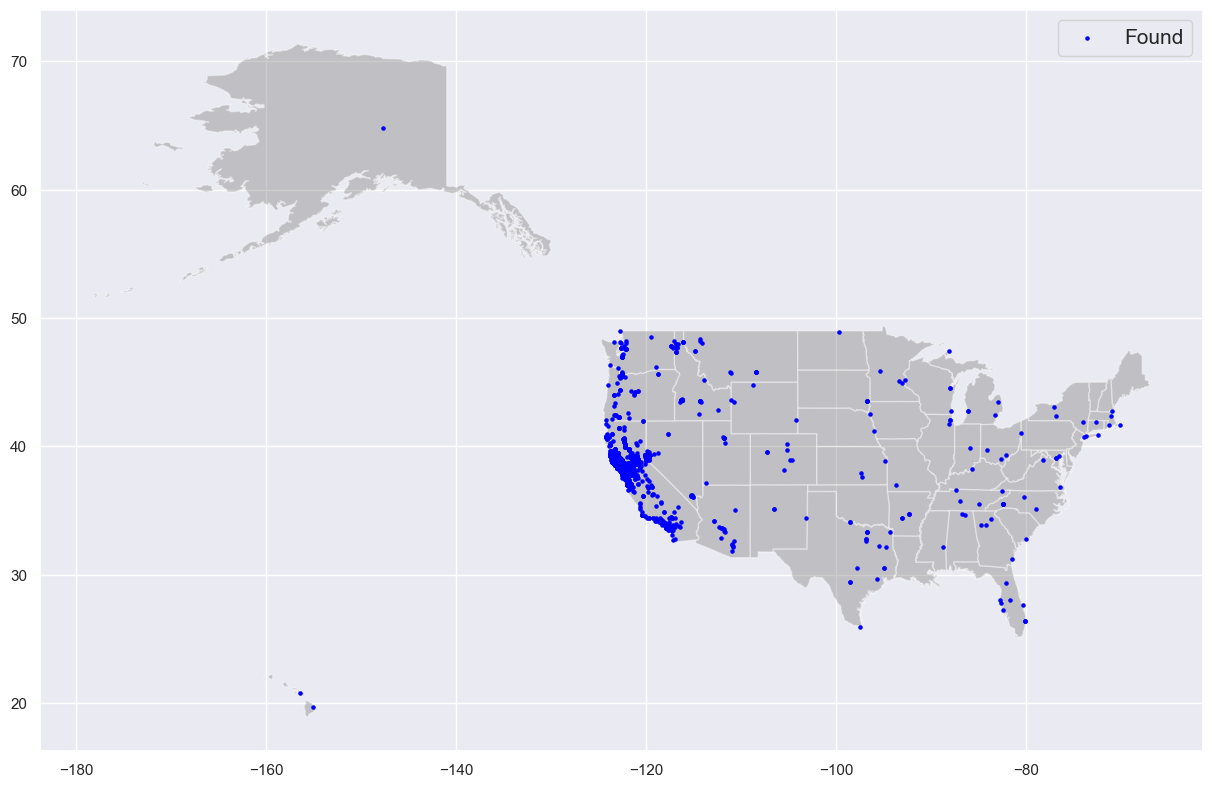

In [147]:
os.environ['SHAPE_RESTORE_SHX'] = 'YES'

street_map = gpd.read_file('files_for_analysis/States_shapefile.shp')
crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df.plot(ax=ax,
            markersize=5,
            color='blue',
            marker='o',
            label='Found')

plt.legend(prop={'size':15})

### Removing outliers

In [148]:
outliers_location_latitude = df[df['Latitude'] > 60]
outliers_location_longitude = df[df['Longitude'] < -150]

outliers_location = pd.concat([outliers_location_latitude, outliers_location_longitude])
outliers_location

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Kennel Number,Intake Date,Outcome Date,...,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Days in Shelter,Zip Code,Latitude,Longitude
11196,BUDDY,DOG,SIBERIAN HUSKY/MIX,BLACK/WHITE,Neutered,LARGE,NaN,DS67,2015-01-06,2015-01-07,...,RETURN TO OWNER,OVER THE COUNTER_WEB,HEALTHY,HEALTHY,COUNTY,OUT OF COUNTY,1,99701,64.841300,-147.718335
8472,*JESSICA,OTHER,RABBIT SH,WHITE/TRICOLOR,Spayed,SMALL,08/06/2014,CA01,2015-07-18,2015-08-08,...,ADOPTION,WALKIN,HEALTHY,HEALTHY,SANTA ROSA,OUT OF COUNTY,21,96753,20.776144,-156.453118
20452,*GARTH,DOG,AUST CATTLE DOG/MIX,WHITE/TAN,Neutered,MED,11/03/2013,DA09,2014-02-22,2014-03-08,...,ADOPTION,WALKIN,HEALTHY,HEALTHY,COUNTY,OUT OF COUNTY,14,96720,19.717275,-155.085635


In [149]:
print("Dataframe shape before dropping outliers: ", df.shape)
df = df.drop(outliers_location.index, axis=0)
print("Dataframe shape after dropping outliers: ", df.shape)

Dataframe shape before dropping outliers:  (26112, 22)
Dataframe shape after dropping outliers:  (26109, 22)


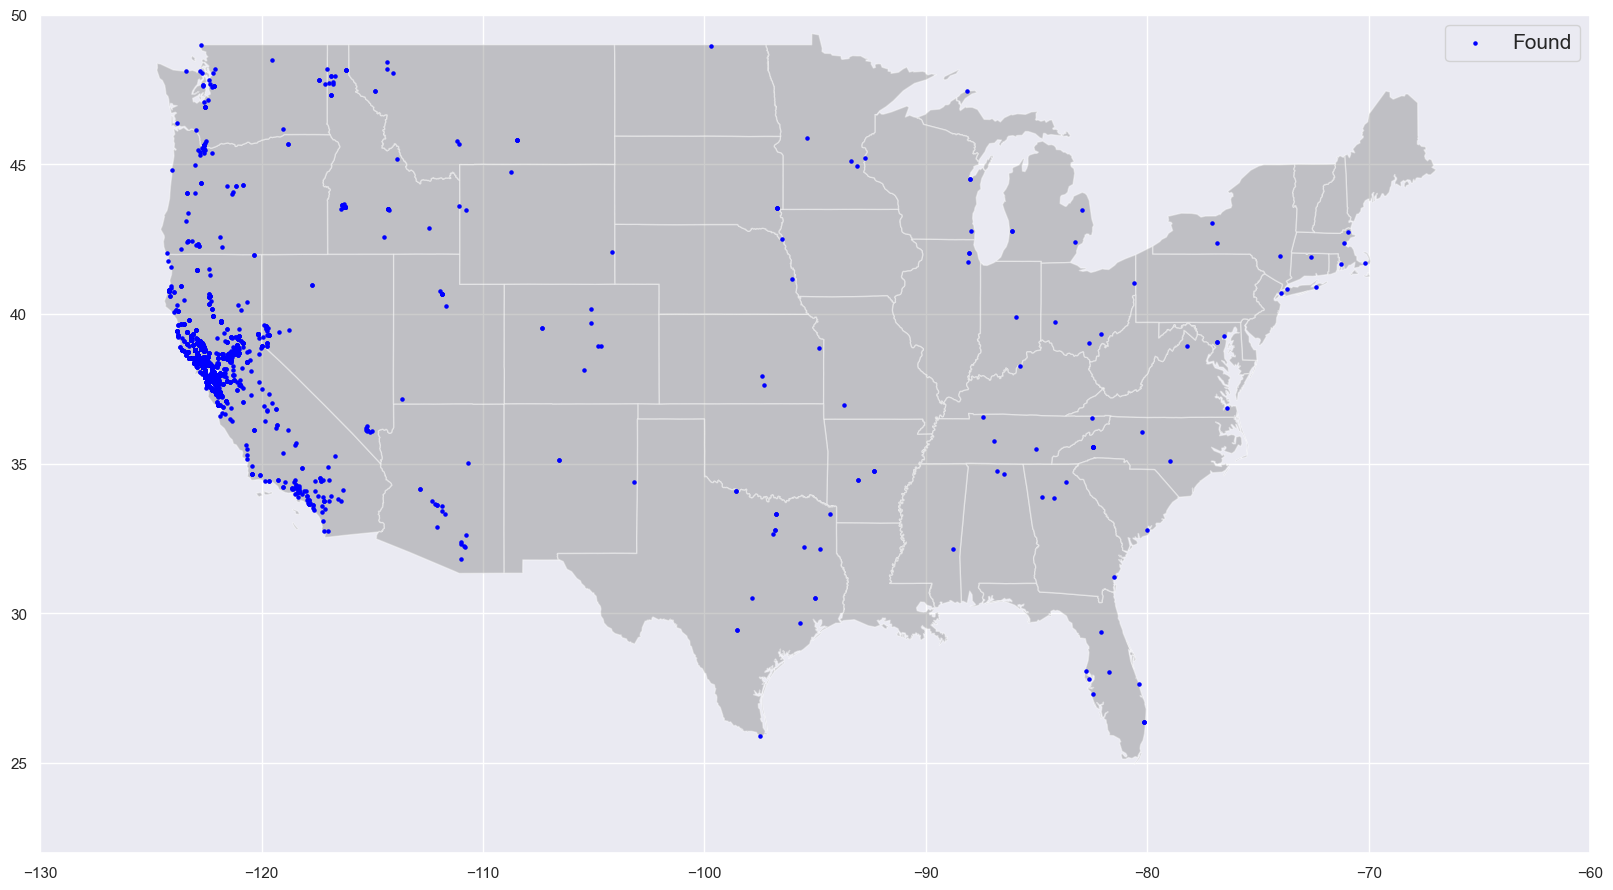

In [150]:
fig, ax = plt.subplots(figsize=(20,20))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df.plot(ax=ax,
            markersize=5,
            color='blue',
            marker='o',
            label='Found')

ax.set_xlim([-130, -60])
ax.set_ylim([22, 50])

plt.legend(prop={'size':15})

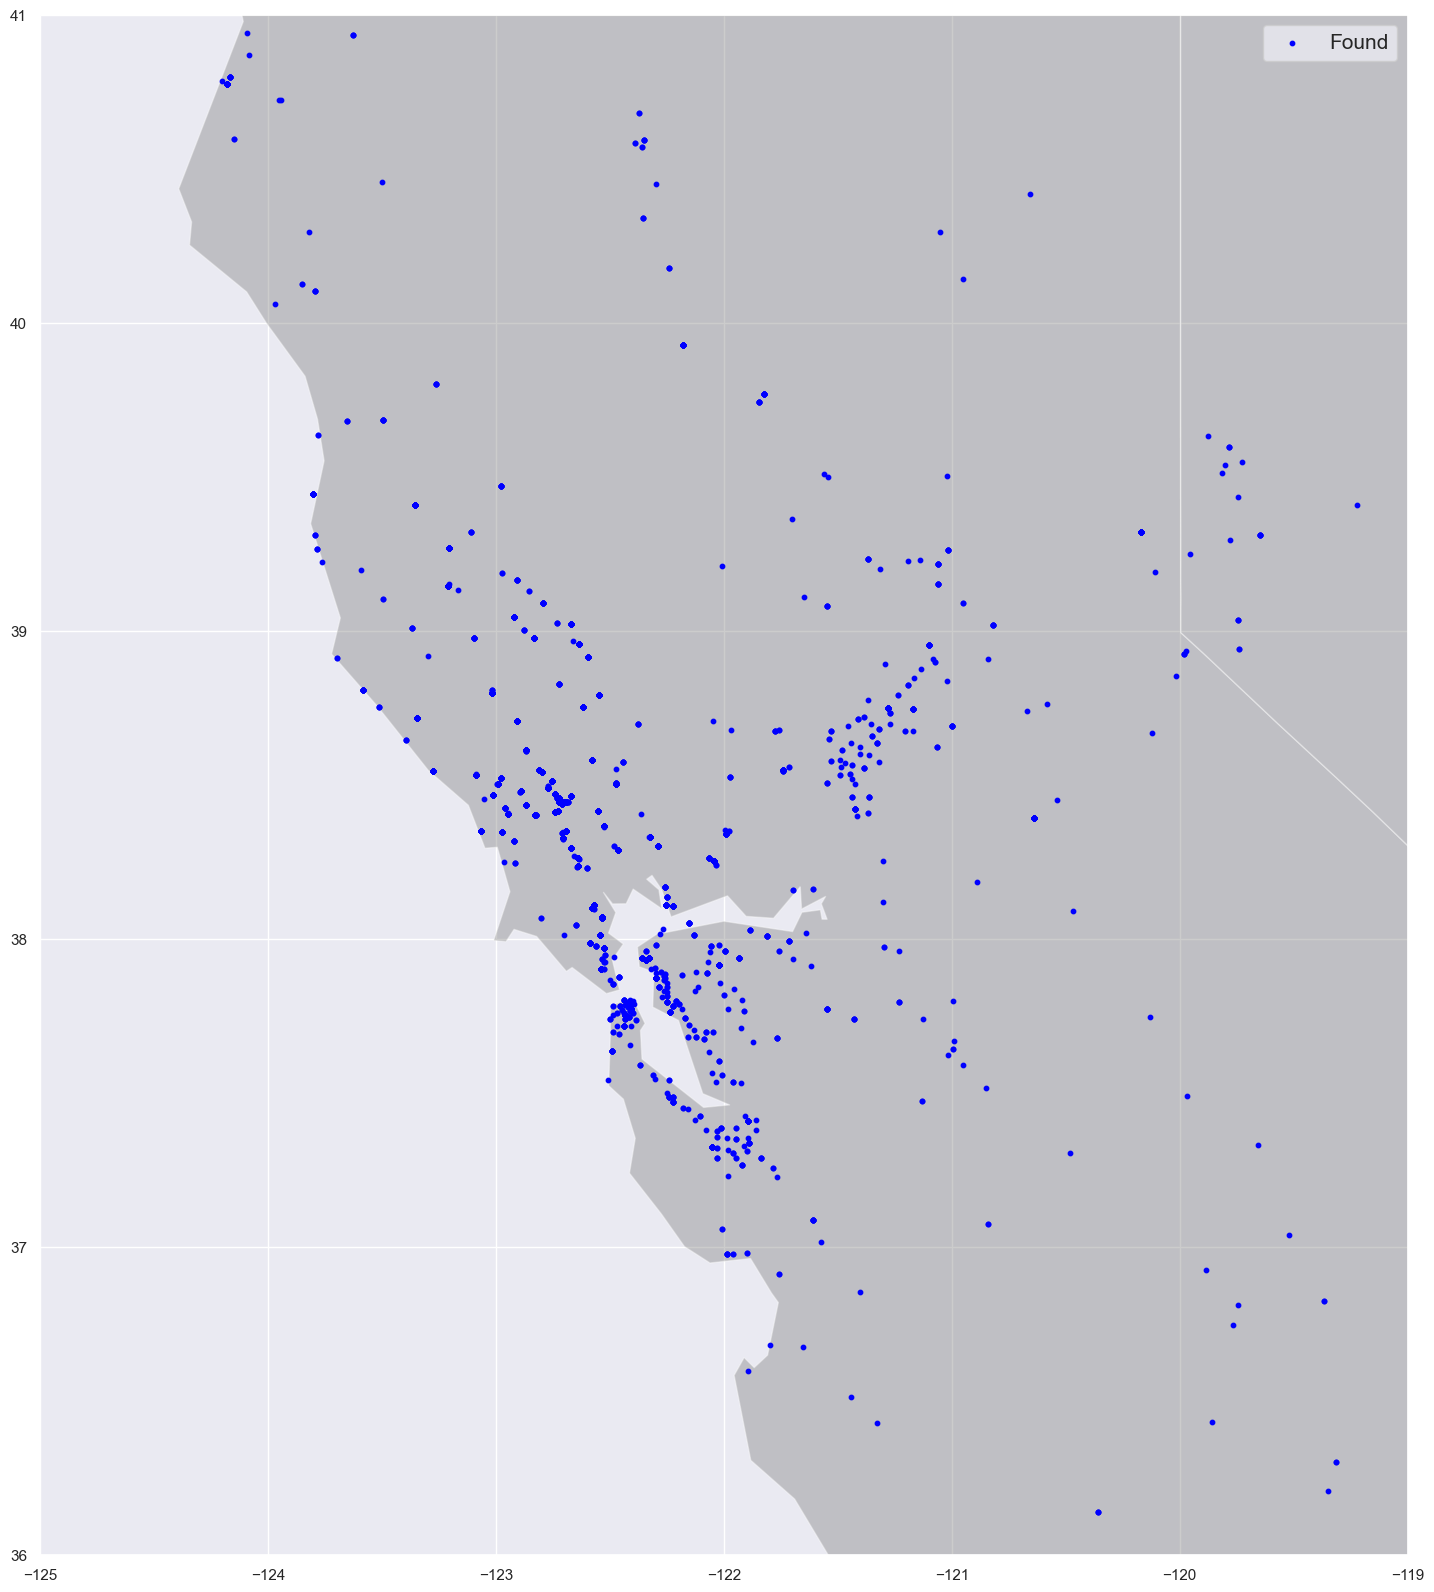

In [151]:
fig, ax = plt.subplots(figsize=(20,20))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df.plot(ax=ax,
            markersize=10,
            color='blue',
            marker='o',
            alpha=1,
            label='Found')

ax.set_xlim([-125, -119])
ax.set_ylim([36, 41])

plt.legend(prop={'size':15})

## Handle dates

In [152]:
print(df.columns)

Index(['Name', 'Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth',
       'Kennel Number', 'Intake Date', 'Outcome Date', 'Intake Type',
       'Intake Subtype', 'Outcome Type', 'Outcome Subtype', 'Intake Condition',
       'Outcome Condition', 'Intake Jurisdiction', 'Outcome Jurisdiction',
       'Days in Shelter', 'Zip Code', 'Latitude', 'Longitude'],
      dtype='object')


In [153]:
df.isnull().sum()

Name                    6104
Type                       0
Breed                      0
Color                      0
Sex                        0
Size                      35
Date Of Birth           6110
Kennel Number              0
Intake Date                0
Outcome Date               0
Intake Type                0
Intake Subtype             0
Outcome Type               4
Outcome Subtype          274
Intake Condition           0
Outcome Condition        316
Intake Jurisdiction        0
Outcome Jurisdiction    3498
Days in Shelter            0
Zip Code                   0
Latitude                3528
Longitude               3528
dtype: int64

In [154]:
df["Intake Date"] = pd.to_datetime(df["Intake Date"])
df["Date Of Birth"] = pd.to_datetime(df["Date Of Birth"])

valid_rows = df[df["Date Of Birth"].notnull()].index
df.loc[valid_rows, 'Age'] = (df.loc[valid_rows, 'Intake Date'] - df.loc[valid_rows, 'Date Of Birth']).dt.days.astype(int) // 365

avg_age = df["Age"].mean()
avg_age = round(avg_age, 0)

df["Age"].fillna(avg_age, inplace=True)

df.drop(['Date Of Birth'], axis=1, inplace=True)
df

C:\Users\CEM\AppData\Local\Temp\ipykernel_7776\1498867289.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Age"].fillna(avg_age, inplace=True)


,Name,Type,Breed,Color,Sex,Size,Kennel Number,Intake Date,Outcome Date,Intake Type,...,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Days in Shelter,Zip Code,Latitude,Longitude,Age
0,NaN,OTHER,CHICKEN,BROWN,Female,SMALL,LS01,2023-10-15,2023-11-18,CONFISCATE,...,REFERRAL-O,UNKNOWN,PENDING,COUNTY,COUNTY,34,95403,38.471644,-122.739825,3.0
1,CUPCAKE,DOG,MALTESE/POODLE TOY,WHITE,Spayed,TOY,DA04,2023-07-05,2023-08-08,STRAY,...,SCAS WEB,UNKNOWN,PENDING,SANTA ROSA,COUNTY,34,95441,38.708540,-122.907370,8.0
2,*DEEDEE,CAT,DOMESTIC SH,BRN TABBY/TORTIE,Spayed,KITTN,LOBBY,2023-10-17,2023-11-18,OWNER SURRENDER,...,SCAS WEB,HEALTHY,HEALTHY,COUNTY,*WINDSOR,32,95492,38.541355,-122.800260,0.0
3,*ATIELA,CAT,DOMESTIC SH,SLVR TABBY,Neutered,SMALL,CA02,2023-09-01,2023-09-29,CONFISCATE,...,HSSC,HEALTHY,HEALTHY,COUNTY,COUNTY,28,95407,38.412709,-122.741215,2.0
4,*MINDY,CAT,DOMESTIC MH,BRN TABBY,Spayed,SMALL,LOBBY,2023-08-16,2023-11-18,STRAY,...,SCAS WEB,HEALTHY,HEALTHY,SANTA ROSA,*WINDSOR,94,95492,38.541355,-122.800260,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26107,OYNX,CAT,DOMESTIC SH,BLACK,Male,SMALL,CS05,2021-04-08,2021-04-13,STRAY,...,OVER THE COUNTER_MCHIP,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,5,95409,38.464170,-122.670710,3.0
26108,MISSY,DOG,CHIHUAHUA SH,BLACK/BROWN,Spayed,SMALL,TX,2014-12-31,2015-02-11,STRAY,...,REFERRAL,UNTREATABLE,UNTREATABLE,SANTA ROSA,COUNTY,42,95404,38.438070,-122.712470,12.0
26109,*DIMITRI,DOG,GERM SHEPHERD/MIX,BROWN/BLACK,Neutered,LARGE,DA44,2021-01-09,2021-03-06,STRAY,...,B A GERMAN,HEALTHY,TREATABLE/REHAB,SANTA ROSA,OUT OF COUNTY,56,94947,38.101390,-122.578090,2.0
26110,PRINCESS,DOG,CHIHUAHUA SH/MIX,TAN/WHITE,Spayed,PUPPY,DA48,2017-03-31,2017-04-08,ADOPTION RETURN,...,WALKIN,HEALTHY,HEALTHY,SANTA ROSA,*CLOVERDALE,8,95425,38.806300,-123.017850,0.0


In [155]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

def get_date_info_from_single_column(df, column_name):
    df[column_name] = pd.to_datetime(df[column_name])
    df[column_name + '_year'] = df[column_name].dt.year
    df[column_name + '_month'] = df[column_name].dt.month
    df[column_name + '_day'] = df[column_name].dt.day
    df[column_name + '_weekday'] = df[column_name].dt.weekday
    df[column_name + '_season'] = df[column_name + '_month'].apply(get_season)

get_date_info_from_single_column(df, 'Intake Date')

## Remove age outliers

In [156]:
df["Age"].unique()

array([ 3.,  8.,  0.,  2., 11.,  1., 12., 14.,  7.,  6.,  4., 10.,  5.,
       13., 17., -1., 18.,  9., -2., 15., 16., 25., 19., 20., 21., 23.,
       22., 24., 30., -3., -4.])

In [157]:
df = df[df["Age"] >= 0]

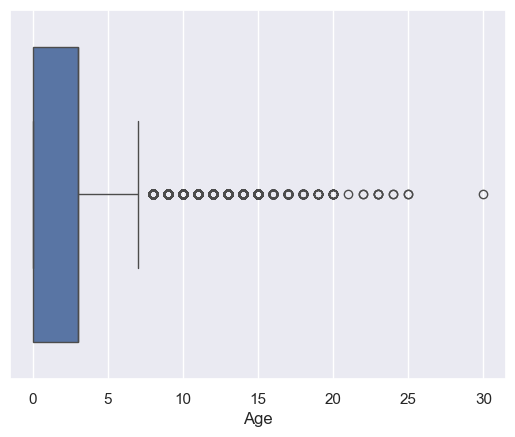

In [158]:
sns.boxplot(x=df["Age"])
plt.show()

In [159]:
df = df[df["Age"] < 25]

## Names analysis

In [160]:
df["Name"].fillna("Unknown", inplace=True)
df["HasName"] = df["Name"].apply(lambda x: 0 if x == "Unknown" else 1)

C:\Users\CEM\AppData\Local\Temp\ipykernel_7776\278893833.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Name"].fillna("Unknown", inplace=True)


In [161]:
df["Name"].value_counts()

Name
Unknown              6102
BUDDY                 152
LUNA                  134
BELLA                 130
MAX                   108
                     ... 
SPIRIT PUPPY HEAD       1
NATSU                   1
D.O.G.                  1
KIKA                    1
*KIN                    1
Name: count, Length: 7101, dtype: int64

In [162]:
df['Name'] = df['Name'].str.replace('*', '')
df["Name first letter"] = df["Name"].str[0]
df["Name contains digits"] = df['Name'].str.contains('\d').astype(int)
df["Name is short (less than 5 letters)"] = df['Name'].str.len() < 5
df["Name is short (less than 5 letters)"] = df["Name is short (less than 5 letters)"].astype(int)

In [163]:
df["Name"].value_counts().to_dict()
df["Name"].value_counts().to_csv('files_for_analysis/unique_names.csv')

Popular animal names 2023 (https://parade.com/living/most-popular-pet-names-2023)

In [164]:
popular_names = ["Luna", "Bella", "Charlie", "Daisy", "Max", "Lucy", "Cooper", "Bailey", "Milo", "Coco", "Oliver", "Leo", "Lily", "Kitty", "Loki"]
popular_names = [x.upper() for x in popular_names]

In [165]:
df["Name"] = df["Name"].str.upper()

In [166]:
df["Name is popular"] = df["Name"].apply(lambda x: 1 if x in popular_names else 0)

In [167]:
names_less_occurence = df["Name"].value_counts()[df["Name"].value_counts() < 5].index
df["Name"].replace(names_less_occurence, "OTHER", inplace=True)

C:\Users\CEM\AppData\Local\Temp\ipykernel_7776\849717390.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Name"].replace(names_less_occurence, "OTHER", inplace=True)


In [168]:
df["Name is popular"].value_counts()

Name is popular
0    24956
1     1113
Name: count, dtype: int64

In [169]:
len(df['Name'].value_counts())

915

In [170]:
names_less_occurence = df["Name"].value_counts()[df["Name"].value_counts() < 10].index
df["Name"].replace(names_less_occurence, "OTHER", inplace=True)
len(df['Name'].value_counts())

401

In [171]:
df.drop(['Name'], axis=1, inplace=True)

## Type analysis

In [172]:
unique_types = df['Type'].unique().tolist()
unique_types

['OTHER', 'DOG', 'CAT']

<Axes: xlabel='Type', ylabel='count'>

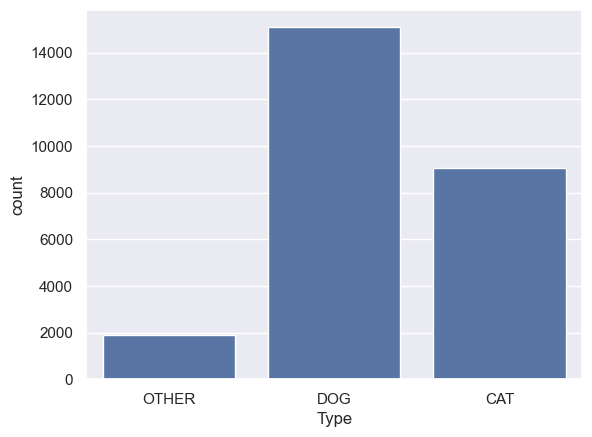

In [173]:
sns.set(style="darkgrid")
sns.countplot(x="Type", data=df)

### In shelters, the majority are dogs and cats, so they are the ones I will focus on

In [174]:
df = df[df['Type'] != 'OTHER']

## Breed analysis

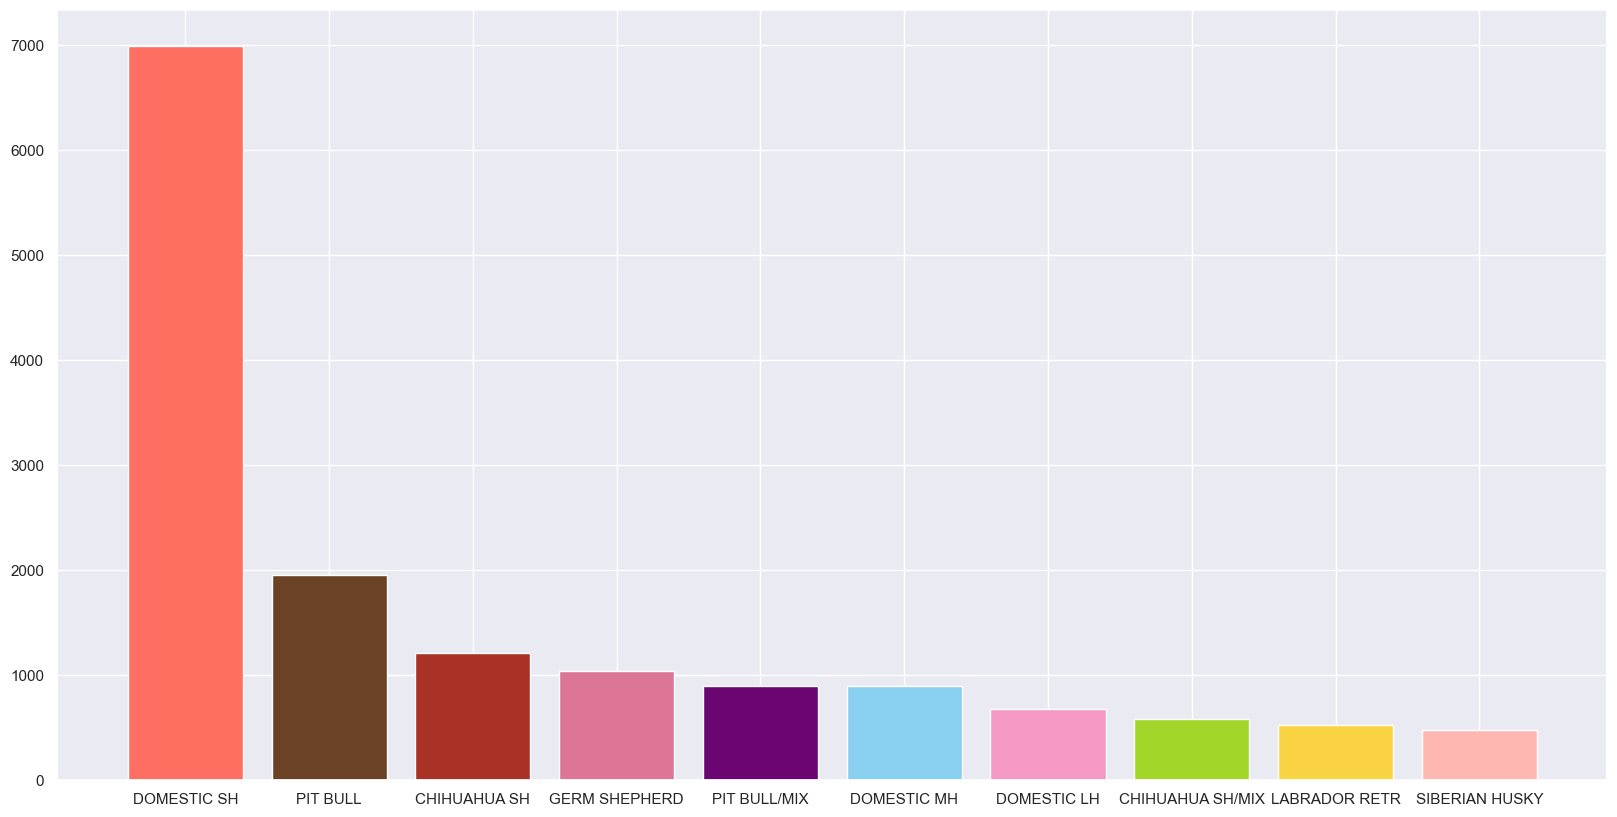

In [175]:
topTenBreeds = df["Breed"].value_counts().head(10)
topTenBreeds = topTenBreeds.to_dict()
colors = ['#FF6F61', '#6B4226', '#A93226', '#DD7596', '#6A0572',
               '#89CFF0', '#F49AC2', '#A2D729', '#F9D342', '#FFB7B2']

plt.figure(figsize=(20,10))
plt.bar(topTenBreeds.keys(), topTenBreeds.values(), color=colors)
plt.show()

### Based on the graph, domestic short-haired animals are the majority of this dataset

### Dogs

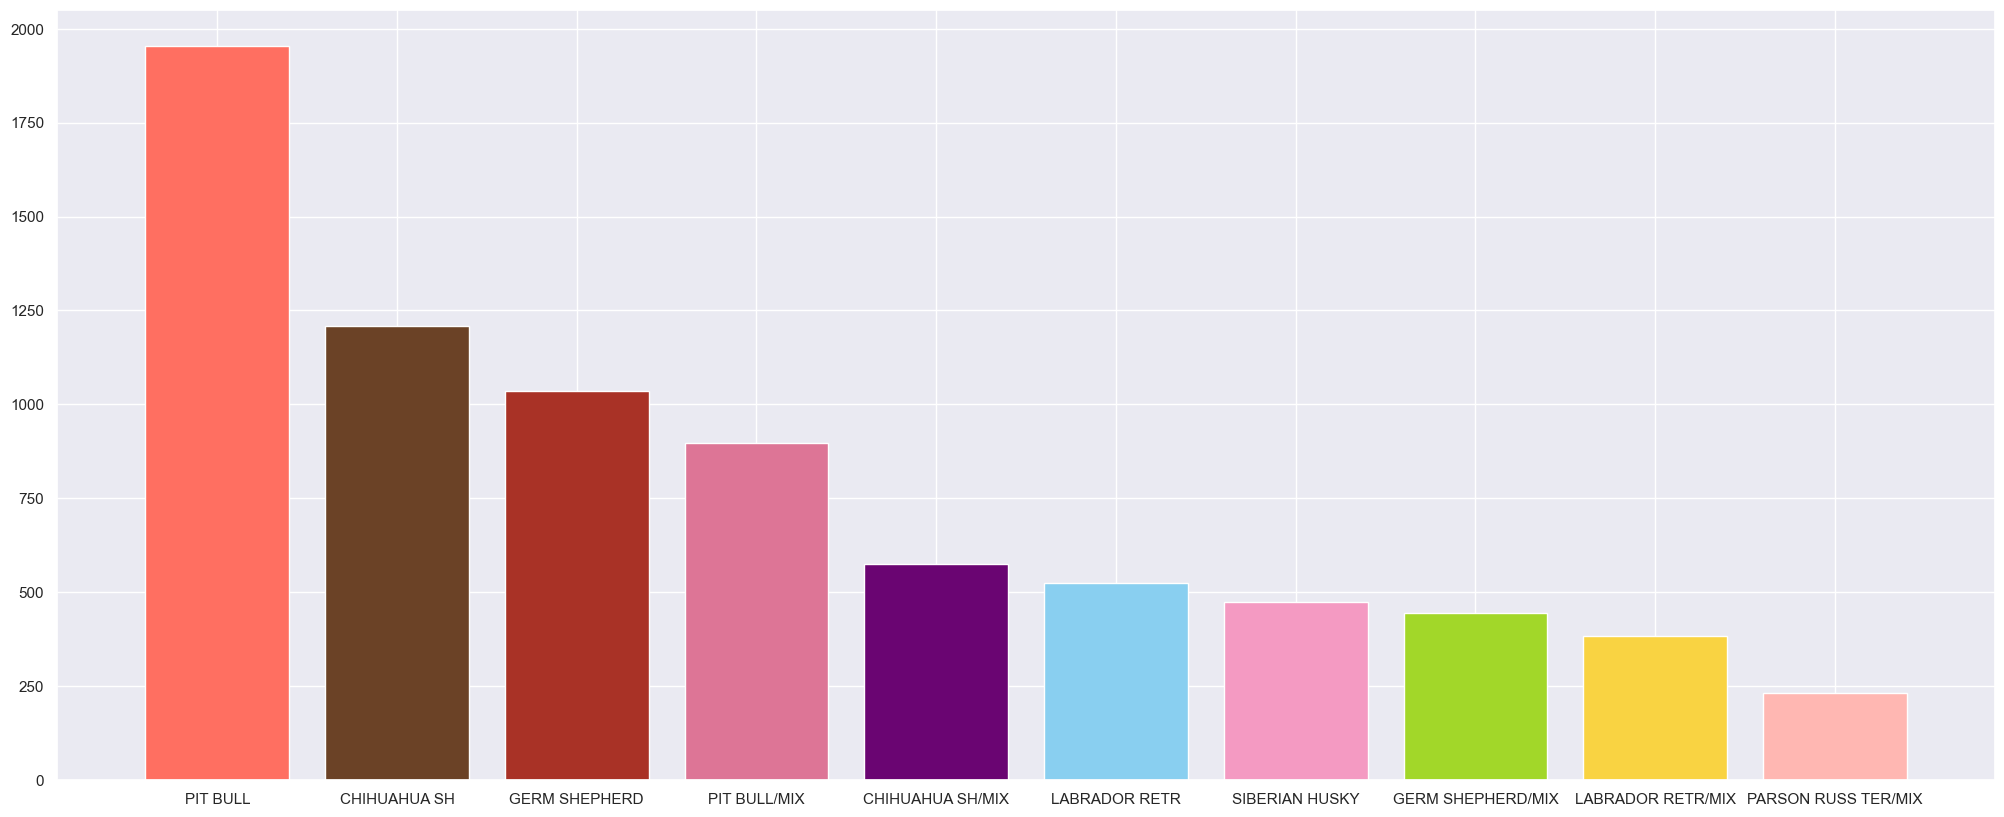

In [176]:
df_dogs = df[df["Type"] == "DOG"]
topTenBreedsDogs = df_dogs["Breed"].value_counts().head(10)
topTenBreedsDogs = topTenBreedsDogs.to_dict()
colors = ['#FF6F61', '#6B4226', '#A93226', '#DD7596', '#6A0572',
               '#89CFF0', '#F49AC2', '#A2D729', '#F9D342', '#FFB7B2']

plt.figure(figsize=(25,10))
plt.bar(topTenBreedsDogs.keys(), topTenBreedsDogs.values(), color=colors)
plt.show()

### Cats

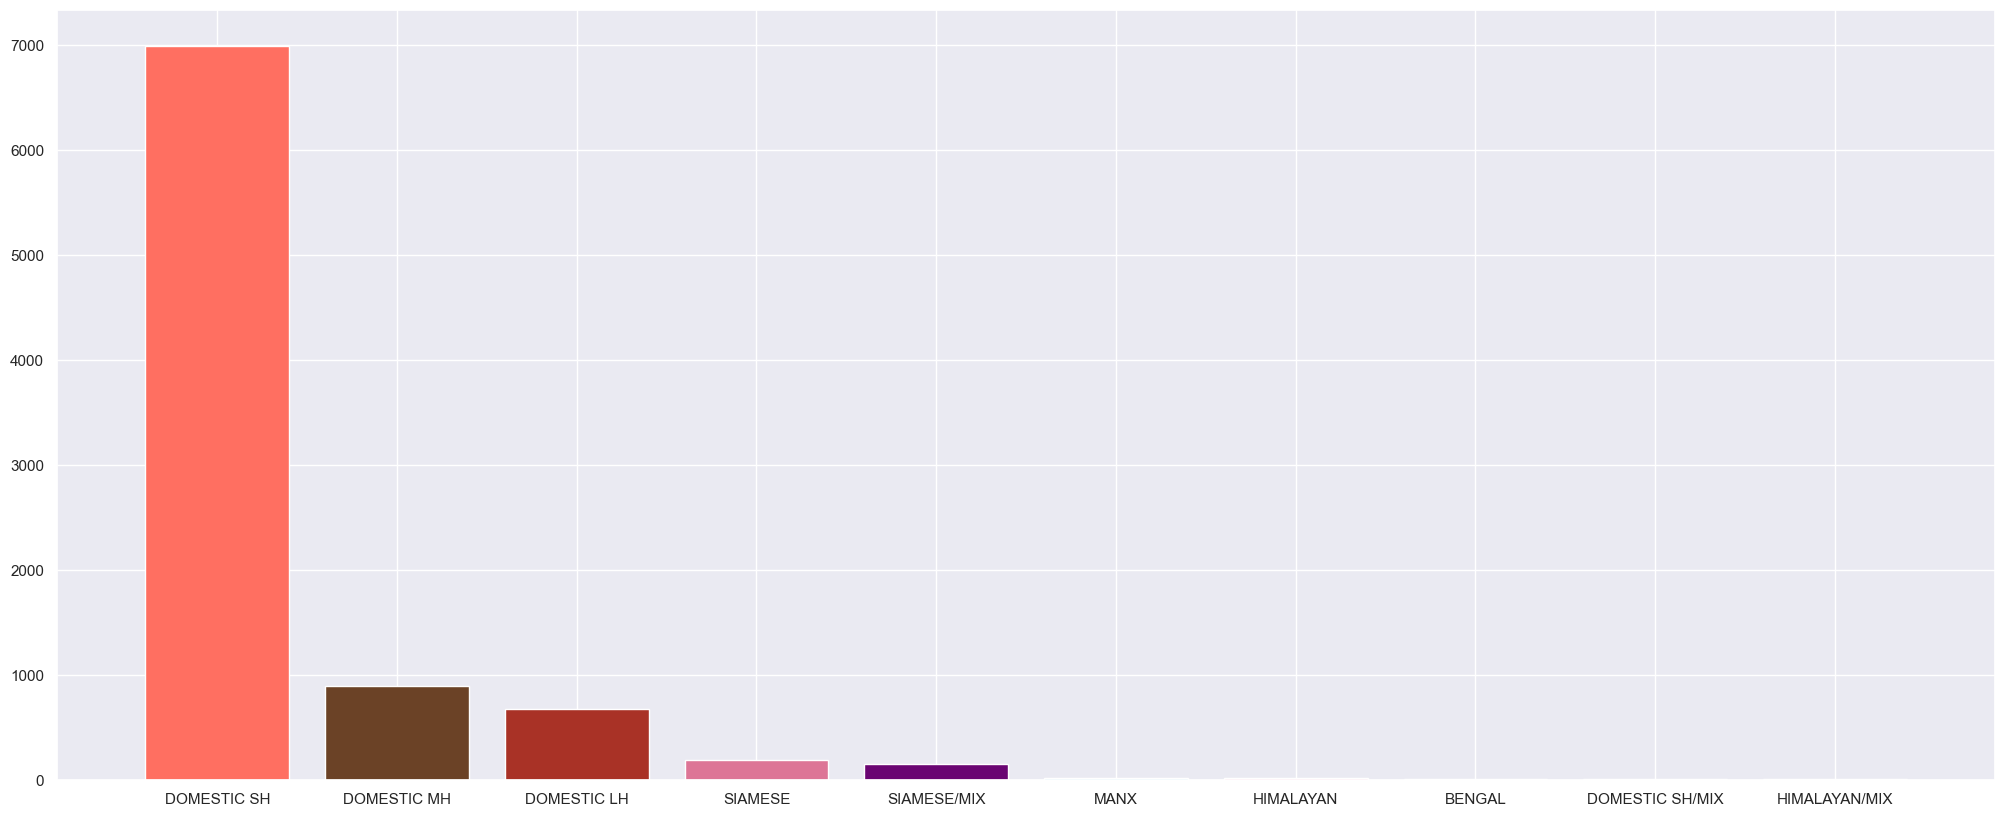

In [177]:
df_cats = df[df["Type"] == "CAT"]
topTenBreedsCats = df_cats["Breed"].value_counts().head(10)
topTenBreedsCats = topTenBreedsCats.to_dict()
colors = ['#FF6F61', '#6B4226', '#A93226', '#DD7596', '#6A0572',
               '#89CFF0', '#F49AC2', '#A2D729', '#F9D342', '#FFB7B2']

plt.figure(figsize=(25,10))
plt.bar(topTenBreedsCats.keys(), topTenBreedsCats.values(), color=colors)
plt.show()

In [178]:
df["Breed"] = df["Breed"].str.lower()

def categorize_breed(breed):
    if "mix" in breed or "/" in breed or "domestic" in breed:
        return "mixed"
    else:
        return "pure"

df["Breed"] = df["Breed"].apply(categorize_breed)

In [179]:
df["Sex"].unique()

array(['Spayed', 'Neutered', 'Female', 'Male', 'Unknown'], dtype=object)

In [180]:
df = df.replace("Neutered", "Male")
df = df.replace("Spayed", "Female")

In [181]:
sorted(df["Color"].unique())

['AGOUTI',
 'AGOUTI/BRN TABBY',
 'APRICOT',
 'APRICOT/WHITE',
 'BL BRINDLE',
 'BL BRINDLE/BLACK',
 'BL BRINDLE/GRAY',
 'BL BRINDLE/TAN',
 'BL BRINDLE/WHITE',
 'BLACK',
 'BLACK/BL BRINDLE',
 'BLACK/BLACK',
 'BLACK/BLK SMOKE',
 'BLACK/BLK TABBY',
 'BLACK/BLUE',
 'BLACK/BLUE MERLE',
 'BLACK/BLUE TICK',
 'BLACK/BR BRINDLE',
 'BLACK/BRN MERLE',
 'BLACK/BROWN',
 'BLACK/CHOCOLATE',
 'BLACK/CREAM',
 'BLACK/GOLD',
 'BLACK/GRAY',
 'BLACK/ORANGE',
 'BLACK/RED',
 'BLACK/SILVER',
 'BLACK/TAN',
 'BLACK/TRICOLOR',
 'BLACK/WHITE',
 'BLACK/YELLOW',
 'BLK SMOKE',
 'BLK SMOKE/WHITE',
 'BLK TABBY',
 'BLK TABBY/GRAY',
 'BLK TABBY/GRAY TIGER',
 'BLK TABBY/TORTIE',
 'BLK TABBY/WHITE',
 'BLK TIGER/GRAY',
 'BLK TIGER/TAN',
 'BLONDE',
 'BLUE',
 'BLUE CREAM',
 'BLUE CREAM/BRN TABBY',
 'BLUE CREAM/CALICO',
 'BLUE CREAM/TORTIE',
 'BLUE CREAM/WHITE',
 'BLUE MERLE',
 'BLUE MERLE/BLACK',
 'BLUE MERLE/GRAY',
 'BLUE MERLE/TAN',
 'BLUE MERLE/WHITE',
 'BLUE PT',
 'BLUE PT/WHITE',
 'BLUE TABBY',
 'BLUE TICK',
 'BLUE TICK/

In [182]:
def get_color_type(color):
    if "/" in color:
        return "Mixed"
    else:
        return "Solid"

def change_color(color):
    if "/" in color:
        return color.split("/")[0]
    else:
        return color

df["ColorType"] = df["Color"].apply(get_color_type)
df["Color"] = df["Color"].apply(change_color)

In [183]:
sorted(df["Color"].unique())

['AGOUTI',
 'APRICOT',
 'BL BRINDLE',
 'BLACK',
 'BLK SMOKE',
 'BLK TABBY',
 'BLK TIGER',
 'BLONDE',
 'BLUE',
 'BLUE CREAM',
 'BLUE MERLE',
 'BLUE PT',
 'BLUE TABBY',
 'BLUE TICK',
 'BLUE TIGER',
 'BR BRINDLE',
 'BRN MERLE',
 'BRN TABBY',
 'BRN TIGER',
 'BROWN',
 'BUFF',
 'CALICO',
 'CALICO PT',
 'CHOC PT',
 'CHOCOLATE',
 'CREAM',
 'CRM TABBY',
 'FAWN',
 'FLAME PT',
 'GOLD',
 'GRAY',
 'GRAY TABBY',
 'GRAY TIGER',
 'LILAC PT',
 'LIVER',
 'LIVER TICK',
 'LYNX PT',
 'ORANGE',
 'ORG TABBY',
 'ORG TIGER',
 'RED',
 'RED MERLE',
 'RED TICK',
 'RUDDY',
 'SABLE',
 'SEAL PT',
 'SILVER',
 'SL LYNX PT',
 'SLVR TABBY',
 'SLVR TIGER',
 'TAN',
 'TORTIE',
 'TORTIE PT',
 'TRICOLOR',
 'UNKNOWN',
 'WHITE',
 'Y BRINDLE',
 'YELLOW']

In [184]:
def fix_color_names(df):
    df.loc[df["Color"].str.contains("GRAY"), "Color"] = "GRAY"    
    df.loc[df["Color"].str.contains("BLUE"), "Color"] = "BLUE"
    df.loc[df["Color"].str.contains("BLK"), "Color"] = "BLACK"
    df.loc[df["Color"].str.contains("BRN"), "Color"] = "BROWN"    
    df.loc[df["Color"].str.contains("RED"), "Color"] = "RED"

    df.loc[df["Color"] == "BR BRINDLE", "Color"] = "BROWN"
    df.loc[df["Color"] == "ORG TABBY", "Color"] = "ORANGE"

    df.loc[(df["Color"] == "SL LYNX PT") | (df["Color"] == "SLVR TABBY"), "Color"] = "SILVER"
    df.loc[df["Color"] == "TORTIE PT", "Color"] = "TORTIE"

    return df


In [185]:
df = fix_color_names(df)

In [186]:
df.head()

,Type,Breed,Color,Sex,Size,Kennel Number,Intake Date,Outcome Date,Intake Type,Intake Subtype,...,Intake Date_month,Intake Date_day,Intake Date_weekday,Intake Date_season,HasName,Name first letter,Name contains digits,Name is short (less than 5 letters),Name is popular,ColorType
1,DOG,mixed,WHITE,Female,TOY,DA04,2023-07-05,2023-08-08,STRAY,FIELD,...,7,5,2,summer,1,C,0,0,0,Solid
2,CAT,mixed,BROWN,Female,KITTN,LOBBY,2023-10-17,2023-11-18,OWNER SURRENDER,OVER THE COUNTER,...,10,17,1,autumn,1,D,0,0,0,Mixed
3,CAT,mixed,SILVER,Male,SMALL,CA02,2023-09-01,2023-09-29,CONFISCATE,FIELD,...,9,1,4,autumn,1,A,0,0,0,Solid
4,CAT,mixed,BROWN,Female,SMALL,LOBBY,2023-08-16,2023-11-18,STRAY,OVER THE COUNTER,...,8,16,2,summer,1,M,0,0,0,Solid
5,CAT,mixed,BROWN,Male,KITTN,WESTFARM,2023-08-29,2023-11-17,STRAY,OVER THE COUNTER,...,8,29,1,summer,1,S,0,0,0,Solid


## Intake analysis

In [187]:
df["Intake Condition"].unique()

array(['UNKNOWN', 'HEALTHY', 'TREATABLE/REHAB', 'TREATABLE/MANAGEABLE',
       'UNTREATABLE'], dtype=object)

In [188]:
df = df.replace("TREATABLE/MANAGEABLE", "TREATABLE")
df = df.replace("TREATABLE/REHAB", "TREATABLE")

In [189]:
df["Days in Shelter"].unique()

array([  34,   32,   28,   94,   80,   70,   24,   85,    0,   91,    5,
         38,    2,   26,   56,   30,    1,   31,  206,   43,   18,    4,
          3,    6,   14,   35,  107,   23,   60,   68,  105,   15,   29,
          9,   44,   22,   45,   55,   67,   27,   54,   49,   69,    7,
         25,   41,    8,   20,   11,  126,   46,   12,   47,   76,   42,
         98,   13,   36,   39,   64,   52,   17,  110,  119,   33,   37,
        101,   16,   10,  223,   71,   51,   48,  327,  189,   40,   90,
         74,   53,  176,   57,   59,   19,   62,   63,   50,  179,   66,
         73,  111,   77,   21,   88,  162,   86,  172,  254,   81,  120,
         89,  766,  113,  197,  469,  350,  168,  177,   58,   61,   72,
        534,   84,  190,   75,   92,   79,  140,  109,   82,  116,  130,
        229,  211,  208,   65,   93,  210,  117,  212,  235,  280,  104,
         99,  220,  263,  193,  329,  103,  314,  248,  156,  158,   87,
         78,  128,  372,  133,  123,   96,  201,  1

In [190]:
df['Outcome Date'].fillna(df['Intake Date'] + pd.to_timedelta(df['Days in Shelter'], unit='d'), inplace=True)

df['Intake Date'] = pd.to_datetime(df['Intake Date'])
df['Outcome Date'] = pd.to_datetime(df['Outcome Date'])
df['Count Days'] = df['Outcome Date'] - df['Intake Date']
df['Count Days'] = df['Count Days'].dt.days.astype(int)

C:\Users\CEM\AppData\Local\Temp\ipykernel_7776\534580551.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Outcome Date'].fillna(df['Intake Date'] + pd.to_timedelta(df['Days in Shelter'], unit='d'), inplace=True)


In [191]:
df[df['Count Days'] != df['Days in Shelter']][['Count Days', 'Days in Shelter']]

,Count Days,Days in Shelter


### There are no records where intake date is after outcome date

In [192]:
df.head()

,Type,Breed,Color,Sex,Size,Kennel Number,Intake Date,Outcome Date,Intake Type,Intake Subtype,...,Intake Date_day,Intake Date_weekday,Intake Date_season,HasName,Name first letter,Name contains digits,Name is short (less than 5 letters),Name is popular,ColorType,Count Days
1,DOG,mixed,WHITE,Female,TOY,DA04,2023-07-05,2023-08-08,STRAY,FIELD,...,5,2,summer,1,C,0,0,0,Solid,34
2,CAT,mixed,BROWN,Female,KITTN,LOBBY,2023-10-17,2023-11-18,OWNER SURRENDER,OVER THE COUNTER,...,17,1,autumn,1,D,0,0,0,Mixed,32
3,CAT,mixed,SILVER,Male,SMALL,CA02,2023-09-01,2023-09-29,CONFISCATE,FIELD,...,1,4,autumn,1,A,0,0,0,Solid,28
4,CAT,mixed,BROWN,Female,SMALL,LOBBY,2023-08-16,2023-11-18,STRAY,OVER THE COUNTER,...,16,2,summer,1,M,0,0,0,Solid,94
5,CAT,mixed,BROWN,Male,KITTN,WESTFARM,2023-08-29,2023-11-17,STRAY,OVER THE COUNTER,...,29,1,summer,1,S,0,0,0,Solid,80


In [193]:
df.drop(['Count Days'], axis=1, inplace=True)

In [194]:
df["Days in Shelter"].mean()

19.25407799950319

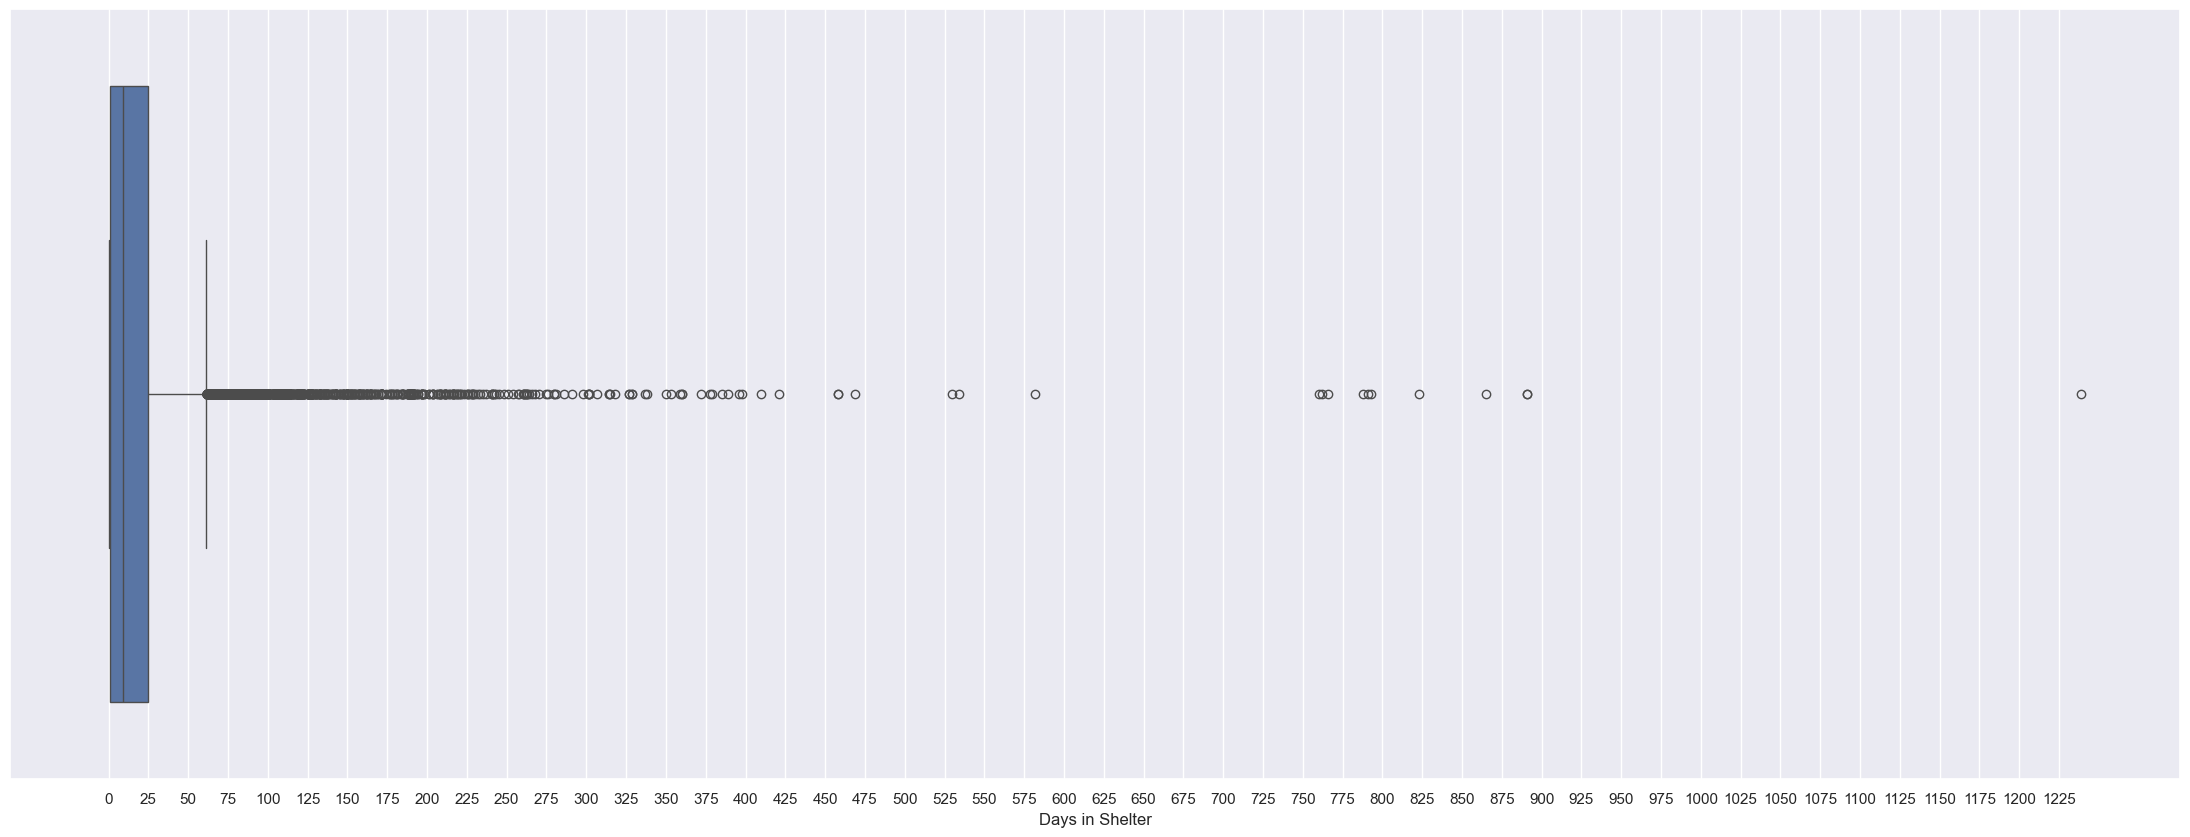

In [195]:
df["Days in Shelter"] = df["Days in Shelter"].astype(int)
plt.figure(figsize=(28,10))
sns.boxplot(x=df["Days in Shelter"])
plt.xticks(np.arange(min(df["Days in Shelter"]), max(df["Days in Shelter"])+1, 25))
plt.show()

In [196]:
len(df[df["Days in Shelter"] > 60])

1536

In [197]:
df = df[df["Days in Shelter"] < 60]

In [198]:
df.isnull().sum()

Type                                      0
Breed                                     0
Color                                     0
Sex                                       0
Size                                     35
Kennel Number                             0
Intake Date                               0
Outcome Date                              0
Intake Type                               0
Intake Subtype                            0
Outcome Type                              0
Outcome Subtype                         183
Intake Condition                          0
Outcome Condition                       227
Intake Jurisdiction                       0
Outcome Jurisdiction                   2863
Days in Shelter                           0
Zip Code                                  0
Latitude                               2905
Longitude                              2905
Age                                       0
Intake Date_year                          0
Intake Date_month               

## Handle size

In [199]:
df['Size'].unique()

array(['TOY', 'KITTN', 'SMALL', 'MED', 'PUPPY', 'LARGE', 'X-LRG', nan],
      dtype=object)

In [200]:
df['Size'] = df['Size'].replace(['TOY', 'PUPPY', 'KITTN'], 'SMALL')
df['Size'] = df['Size'].replace(['MED'], 'MEDIUM')
df['Size'] = df['Size'].replace(['X-LRG'], 'LARGE')
df['Size'].fillna('MEDIUM', inplace=True)

C:\Users\CEM\AppData\Local\Temp\ipykernel_7776\4112111391.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Size'].fillna('MEDIUM', inplace=True)


In [201]:
df['Size'].unique()

array(['SMALL', 'MEDIUM', 'LARGE'], dtype=object)

## Handling outcome subtype

In [202]:
df['Outcome Type'].unique()

array(['ADOPTION', 'TRANSFER', 'RETURN TO OWNER', 'DISPOSAL', 'EUTHANIZE',
       'DIED', 'RTOS', 'VET', 'ESCAPED/STOLEN'], dtype=object)

In [203]:
df['Outcome Type'].value_counts()

Outcome Type
RETURN TO OWNER    8789
ADOPTION           6431
TRANSFER           3988
EUTHANIZE          2966
DISPOSAL            198
DIED                127
RTOS                 53
ESCAPED/STOLEN       12
VET                   2
Name: count, dtype: int64

In [204]:
df = df[df['Outcome Type'].isin(['ADOPTION', 'RETURN TO OWNER'])]

In [205]:
unique_outcome_subtypes = df['Outcome Subtype'].unique()
pd.DataFrame(unique_outcome_subtypes).to_csv('files_for_analysis/unique_outcome_subtypes.csv', index=False)

In [206]:
df['Outcome Subtype'] = df['Outcome Subtype'].astype(str)
df['Outcome Subtype'] = df['Outcome Subtype'].apply(lambda x: 'SCAS' if 'SCAS' in x else x)
df['Outcome Subtype'] = df['Outcome Subtype'].apply(lambda x: 'OVER THE COUNTER' if 'OVER THE COUNTER' in x else x)
df['Outcome Subtype'] = df['Outcome Subtype'].apply(lambda x: 'REFERRAL' if 'REFERRAL' in x else x)
df['Outcome Subtype'] = df['Outcome Subtype'].apply(lambda x: 'EVENT' if 'SPEC EVENT' == x else x)
df['Outcome Subtype'] = df['Outcome Subtype'].apply(lambda x: 'RETURN TO OWNER' if 'RETURN TO OWNER' in x else x)
df['Outcome Subtype'] = df['Outcome Subtype'].apply(lambda x: 'FLD' if 'FLD' in x else x)
df['Outcome Subtype'] = df['Outcome Subtype'].apply(lambda x: 'ADVERT' if 'AD ' in x else x)

In [207]:
df['Outcome Subtype'].value_counts()

Outcome Subtype
OVER THE COUNTER    6650
WALKIN              3012
SCAS                1384
FLD                 1223
INTERNET             713
WESTFARM             428
COMMCAT              390
REFERRAL             382
RETURN TO OWNER      351
EVENT                155
FINDER               102
MEDICAL               99
49ER PET              73
MOB EVENT             61
nan                   50
VOLUNTEER             47
OTH_MEDIA             23
FB OTHER              23
DEBBIE BTQ            14
ADVERT                13
INSTAGRAM             11
RESCUE GRP             8
FACEBOOK               8
Name: count, dtype: int64

In [208]:
df['Outcome Subtype'].fillna('OVER THE COUNTER', inplace=True)

C:\Users\CEM\AppData\Local\Temp\ipykernel_7776\2190040592.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Outcome Subtype'].fillna('OVER THE COUNTER', inplace=True)


In [209]:
df.isnull().sum()

Type                                     0
Breed                                    0
Color                                    0
Sex                                      0
Size                                     0
Kennel Number                            0
Intake Date                              0
Outcome Date                             0
Intake Type                              0
Intake Subtype                           0
Outcome Type                             0
Outcome Subtype                          0
Intake Condition                         0
Outcome Condition                      118
Intake Jurisdiction                      0
Outcome Jurisdiction                   190
Days in Shelter                          0
Zip Code                                 0
Latitude                               214
Longitude                              214
Age                                      0
Intake Date_year                         0
Intake Date_month                        0
Intake Date

## Outcome condition handling

In [210]:
df['Outcome Condition'].unique()

array(['PENDING', 'HEALTHY', 'TREATABLE', 'DEAD', 'UNTREATABLE', nan],
      dtype=object)

In [211]:
df['Outcome Condition'].fillna('PENDING', inplace=True)

C:\Users\CEM\AppData\Local\Temp\ipykernel_7776\2879987720.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Outcome Condition'].fillna('PENDING', inplace=True)


## Handling outcome jurisdiction

In [212]:
df['Outcome Jurisdiction'].unique()

array(['COUNTY', '*WINDSOR', 'SANTA ROSA', '*PETALUMA', 'OUT OF COUNTY',
       nan, '*ROHNERT PARK', '*HEALDSBURG', '*SONOMA', '*COTATI',
       '*SEBASTOPOL', '*CLOVERDALE', 'UNKNOWN'], dtype=object)

In [213]:
df['Outcome Jurisdiction'].value_counts()

Outcome Jurisdiction
SANTA ROSA       6218
COUNTY           4869
OUT OF COUNTY    1352
*WINDSOR         1176
*ROHNERT PARK     488
*PETALUMA         325
*HEALDSBURG       198
*CLOVERDALE       158
*SEBASTOPOL       115
*COTATI            83
*SONOMA            46
UNKNOWN             2
Name: count, dtype: int64

In [214]:
df['Outcome Jurisdiction'] = df['Outcome Jurisdiction'].str.replace('*', '')
df['Outcome Jurisdiction'] = df['Outcome Jurisdiction'].str.replace('UNKNOWN', 'COUNTY')
df['Outcome Jurisdiction'].fillna('COUNTY', inplace=True)
df['Outcome Jurisdiction'].value_counts()

C:\Users\CEM\AppData\Local\Temp\ipykernel_7776\4197448815.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Outcome Jurisdiction'].fillna('COUNTY', inplace=True)


Outcome Jurisdiction
SANTA ROSA       6218
COUNTY           5061
OUT OF COUNTY    1352
WINDSOR          1176
ROHNERT PARK      488
PETALUMA          325
HEALDSBURG        198
CLOVERDALE        158
SEBASTOPOL        115
COTATI             83
SONOMA             46
Name: count, dtype: int64

In [215]:
df.drop(['Zip Code'], axis=1, inplace=True)
df.drop(['Latitude'], axis=1, inplace=True)
df.drop(['Longitude'], axis=1, inplace=True)

In [216]:
df.drop(['Intake Date'], axis=1, inplace=True)

### Deleting outcome date, because it provides the same information as days in shelter

In [217]:
df.drop(['Outcome Date'], axis=1, inplace=True)

In [218]:
df.isnull().sum()

Type                                   0
Breed                                  0
Color                                  0
Sex                                    0
Size                                   0
Kennel Number                          0
Intake Type                            0
Intake Subtype                         0
Outcome Type                           0
Outcome Subtype                        0
Intake Condition                       0
Outcome Condition                      0
Intake Jurisdiction                    0
Outcome Jurisdiction                   0
Days in Shelter                        0
Age                                    0
Intake Date_year                       0
Intake Date_month                      0
Intake Date_day                        0
Intake Date_weekday                    0
Intake Date_season                     0
HasName                                0
Name first letter                      0
Name contains digits                   0
Name is short (l

In [219]:
df.head()

,Type,Breed,Color,Sex,Size,Kennel Number,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,...,Intake Date_month,Intake Date_day,Intake Date_weekday,Intake Date_season,HasName,Name first letter,Name contains digits,Name is short (less than 5 letters),Name is popular,ColorType
1,DOG,mixed,WHITE,Female,SMALL,DA04,STRAY,FIELD,ADOPTION,SCAS,...,7,5,2,summer,1,C,0,0,0,Solid
2,CAT,mixed,BROWN,Female,SMALL,LOBBY,OWNER SURRENDER,OVER THE COUNTER,ADOPTION,SCAS,...,10,17,1,autumn,1,D,0,0,0,Mixed
11,DOG,pure,FAWN,Male,SMALL,DS72,STRAY,OVER THE COUNTER,RETURN TO OWNER,OVER THE COUNTER,...,8,8,1,summer,1,Y,0,1,0,Solid
15,DOG,mixed,BROWN,Female,SMALL,TRUCK,STRAY,FIELD,RETURN TO OWNER,FLD,...,8,8,1,summer,1,M,0,1,0,Solid
16,DOG,mixed,BLACK,Male,MEDIUM,DS83,STRAY,OVER THE COUNTER,RETURN TO OWNER,OVER THE COUNTER,...,8,6,6,summer,1,H,0,0,0,Mixed


In [220]:
df['Kennel Number'].unique()

array(['DA04', 'LOBBY', 'DS72', 'TRUCK', 'DS83', 'DA33', 'DA16', 'DQ111',
       'DS76', 'DS58', 'DS95', 'DA22', 'DS75', 'DA06', 'DA01', 'DS54',
       'DS70', 'DS65', 'DS78', 'DS79', 'DQ118', 'CS05', 'DQ110', 'SMM',
       'CA02', 'DS61', 'CS06', 'MISSING', 'DS55', 'DQ115', 'DA18', 'DS93',
       'DS80', 'DQ117', 'DS60', 'DS53', 'DA32', 'DQ109', 'DQ116', 'DS69',
       'DS57', 'DA30', 'DA28', 'DS74', 'DA23', 'DS73', 'DA19', 'DS87',
       'DA47', 'DA29', 'COOLER', 'DQ114', 'VET', 'TX', 'DS91', 'DA03',
       'DS96', 'CA03', 'CS04', 'DA08', 'DS50', 'DA24', 'RECEIVING',
       'FOSTER', 'DS59', 'DS92', 'DS49', 'DS90', 'DA14', 'DS94', 'DS56',
       'DS84', 'DS52', 'CH', 'DS88', 'DS67', 'DS63', 'DS51', 'WESTFARM',
       'DS66', 'DS68', 'DA36', 'DA20', 'DA27', 'DA35', 'DS89', 'DS71',
       'DA25', 'DA31', 'CI01', 'DA43', 'DS64', 'DS62', 'DA11', 'DA45',
       'DA48', 'DA21', 'DA40', 'DA42', 'DA02', 'DA17', 'DQ112', 'DQ108',
       'MAC', 'DA37', 'DI098', 'DA12', 'DA10', 'DA05', 'DA13', 

In [221]:
all = df['Kennel Number'].unique().tolist()
pd.DataFrame(all).to_csv('files_for_analysis/kennel_numbers.csv', index=False)

In [222]:
locs = ['49ERPET', 
        'COOLER', 
        'CQ', 
        'DEBBIES', 
        'EUTH', 
        'FOSTER', 
        'FREEZER', 
        'HSSC', 
        'K9 ACT CLB', 
        'KINGS KSTL', 
        'LOBBY', 
        'MAC', 
        'MISSING', 
        'MOBILE', 
        'RECEIVING', 
        'SAL', 
        'SMM', 
        'TRUCK', 
        'TX', 
        'UCD', 
        'VET', 
        'WESTFARM', 
        'YARD']

numbers = list(set(all) - set(locs))

In [223]:
df['Kennel Location'] = df['Kennel Number'].apply(lambda x: x if x in locs else 'OTHER')
df['Kennel Number'] = df['Kennel Number'].apply(lambda x: 'OTHER' if x in locs else x)

df['Kennel Number Letters'] = df['Kennel Number'].apply(lambda x: x[:2] if x in numbers else 'OTHER')
df['Kennel Number Numbers'] = df['Kennel Number'].apply(lambda x: x[2:] if x in numbers else -1)

In [224]:
df['Kennel Number Letters'].unique()

array(['DA', 'OTHER', 'DS', 'DQ', 'CS', 'CA', 'CH', 'CI', 'DI'],
      dtype=object)

In [225]:
df['Kennel Number Numbers'].unique()

array(['04', -1, '72', '83', '33', '16', '111', '76', '58', '95', '22',
       '75', '06', '01', '54', '70', '65', '78', '79', '118', '05', '110',
       '02', '61', '55', '115', '18', '93', '80', '117', '60', '53', '32',
       '109', '116', '69', '57', '30', '28', '74', '23', '73', '19', '87',
       '47', '29', '114', '91', '03', '96', '08', '50', '24', '59', '92',
       '49', '90', '14', '94', '56', '84', '52', '', '88', '67', '63',
       '51', '66', '68', '36', '20', '27', '35', '89', '71', '25', '31',
       '43', '64', '62', '11', '45', '48', '21', '40', '42', '17', '112',
       '108', '37', '098', '12', '10', '13', '15', '77', '113', '81',
       '39', '107', '26', '41', '07', '85', '34', '101', '46', '106',
       '097', '82', '44', '38', '09', '099', '86', '104', '105', '102',
       '103', '100'], dtype=object)

In [226]:
df['Kennel Number Numbers'] = df['Kennel Number Numbers'].apply(lambda x: -1 if x == '' else x)
df['Kennel Number Numbers'] = df['Kennel Number Numbers'].astype(int)

In [227]:
df['Kennel Number Numbers'].unique()

array([  4,  -1,  72,  83,  33,  16, 111,  76,  58,  95,  22,  75,   6,
         1,  54,  70,  65,  78,  79, 118,   5, 110,   2,  61,  55, 115,
        18,  93,  80, 117,  60,  53,  32, 109, 116,  69,  57,  30,  28,
        74,  23,  73,  19,  87,  47,  29, 114,  91,   3,  96,   8,  50,
        24,  59,  92,  49,  90,  14,  94,  56,  84,  52,  88,  67,  63,
        51,  66,  68,  36,  20,  27,  35,  89,  71,  25,  31,  43,  64,
        62,  11,  45,  48,  21,  40,  42,  17, 112, 108,  37,  98,  12,
        10,  13,  15,  77, 113,  81,  39, 107,  26,  41,   7,  85,  34,
       101,  46, 106,  97,  82,  44,  38,   9,  99,  86, 104, 105, 102,
       103, 100])

In [228]:
df.drop(['Kennel Number'], axis=1, inplace=True)

In [229]:
df.head().to_csv('files_for_analysis/df_head_post.csv', index=False)
df.to_csv('files_for_analysis/final_df.csv', index=False)

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15220 entries, 1 to 26110
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Type                                 15220 non-null  object 
 1   Breed                                15220 non-null  object 
 2   Color                                15220 non-null  object 
 3   Sex                                  15220 non-null  object 
 4   Size                                 15220 non-null  object 
 5   Intake Type                          15220 non-null  object 
 6   Intake Subtype                       15220 non-null  object 
 7   Outcome Type                         15220 non-null  object 
 8   Outcome Subtype                      15220 non-null  object 
 9   Intake Condition                     15220 non-null  object 
 10  Outcome Condition                    15220 non-null  object 
 11  Intake Jurisdiction              

In [231]:
df_before_encoder = df.copy()

In [232]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

encoder = LabelEncoder()

for column in categorical_columns:
    df[column] = encoder.fit_transform(df[column])

In [233]:
df.to_csv("files_for_analysis/encoded_df.csv")

,Type,Breed,Color,Sex,Size,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,...,Intake Date_season,HasName,Name first letter,Name contains digits,Name is short (less than 5 letters),Name is popular,ColorType,Kennel Location,Kennel Number Letters,Kennel Number Numbers
1,1,0,32,0,2,4,3,0,18,2,...,2,1,3,0,0,0,1,13,4,4
2,0,0,6,0,2,2,18,0,18,0,...,0,1,4,0,0,0,0,9,8,-1
11,1,1,13,1,2,4,18,1,14,0,...,2,1,25,0,1,0,1,13,7,72
15,1,0,6,0,2,4,3,1,8,2,...,2,1,13,0,1,0,1,17,8,-1
16,1,0,3,1,1,4,18,1,14,2,...,2,1,8,0,0,0,0,13,7,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26103,1,1,3,1,2,4,3,0,18,0,...,2,1,1,0,0,0,0,13,4,32
26104,1,1,3,0,0,4,3,1,8,2,...,1,1,19,0,0,0,0,17,8,-1
26107,0,0,3,1,2,4,27,1,14,0,...,1,1,15,0,1,0,1,13,3,5
26108,1,1,3,0,2,4,30,0,15,3,...,3,1,13,0,0,0,0,18,8,-1


In [ ]:
df

In [234]:
information = df.describe()

In [235]:
information.to_csv("files_for_analysis/information.csv")

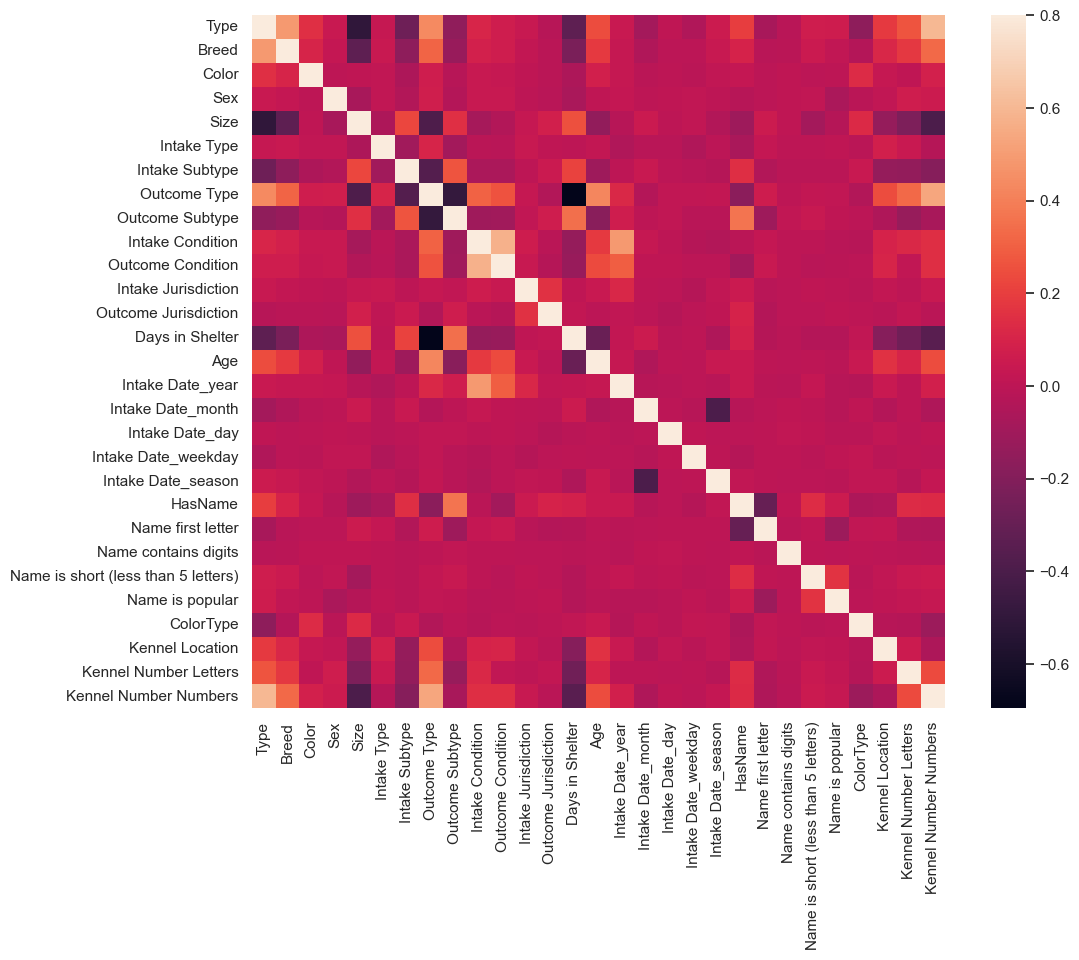

Correlation values with Days in Shelter:
Days in Shelter                        1.000000
Outcome Subtype                        0.346938
Size                                   0.254866
Intake Subtype                         0.213455
HasName                                0.086243
Intake Date_month                      0.057109
Intake Date_year                       0.019847
Outcome Jurisdiction                   0.018633
ColorType                              0.016423
Intake Jurisdiction                    0.009093
Intake Type                            0.001551
Intake Date_weekday                    0.000485
Intake Date_day                       -0.009127
Name contains digits                  -0.010611
Name first letter                     -0.024687
Name is short (less than 5 letters)   -0.030001
Name is popular                       -0.032193
Intake Date_season                    -0.050499
Color                                 -0.058680
Sex                                   -0.066333

In [236]:
corrmat = df.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()
print("Correlation values with Days in Shelter:")
print(corrmat['Days in Shelter'].sort_values(ascending=False))

In [237]:
decision = df["Days in Shelter"]
attributes = df.drop("Days in Shelter", axis=1)
attributes.shape

(15220, 28)

## Average days

In [238]:
import statistics

print(decision.mean())
print(statistics.median(decision))
print(statistics.median(attributes["Age"]))

11.973718791064389
6.0
2.0


In [248]:
cats = df_before_encoder[df_before_encoder.Type == "CAT"]
dogs = df_before_encoder[df_before_encoder.Type == "DOG"]

print(statistics.median(cats["Age"]))
print(statistics.median(dogs["Age"]))

print(statistics.median(cats["Days in Shelter"]))
print(statistics.median(dogs["Days in Shelter"]))

print(statistics.median(cats["Intake Date_month"]))
print(statistics.median(dogs["Intake Date_month"]))

0.0
3.0
15
2
7
7


## Feature selection based on p-value

In [530]:
X = sm.add_constant(attributes)
y = decision

model = sm.OLS(y, X).fit()

p_values = model.pvalues

selected_features = p_values[p_values < 0.05].index

In [531]:
selected_features = selected_features[1:]
selected_features

Index(['Type', 'Sex', 'Size', 'Intake Type', 'Intake Subtype', 'Outcome Type',
       'Intake Condition', 'Intake Jurisdiction', 'Age', 'Intake Date_year',
       'Intake Date_month', 'Intake Date_weekday', 'Intake Date_season',
       'HasName', 'Name is short (less than 5 letters)', 'Name is popular',
       'Kennel Location', 'Kennel Number Letters', 'Kennel Number Numbers'],
      dtype='object')

In [112]:
attributes_selected = attributes[selected_features]

## Split into train, test and val

In [113]:
X_train, X_temp, y_train, y_temp = train_test_split(attributes_selected, decision, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [114]:
X_TRAIN = X_train.copy()
Y_TRAIN = y_train.copy()
X_VAL = X_val.copy()
Y_VAL = y_val.copy()
X_TEST = X_test.copy()
Y_TEST = y_test.copy()

## Method for saving metrics

In [115]:
RESULTS = {}
def save_result_metrics(mae, loss, model_name, model):
    global RESULTS
    RESULTS[model_name] = {}
    RESULTS[model_name]["MAE"] = mae
    RESULTS[model_name]["LOSS (mse)"] = loss
    RESULTS[model_name]["MODEL_OBJECT"] = model

def print_results():
    global RESULTS
    if len(RESULTS) == 0:
        print("No results to print")
        return
    results_df = pd.DataFrame.from_dict(RESULTS, orient='index')
    results_df = results_df.sort_values(by=['MAE'])
    results_df = results_df.reset_index()
    results_df = results_df.rename(columns={'index': 'Model name'})

    return results_df

### Linear regression

In [116]:
def make_linear_regression(X_train, y_train, X_val, y_val, model_name, params={}):
    if "Linear" in model_name:
        model = LinearRegression()
    elif "RandomForest" in model_name:
        model = RandomForestRegressor()
    elif "SVR" in model_name:
        model = SVR()
    elif "KNeighbors" in model_name:
        model = KNeighborsRegressor(params["n_neighbors"])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)

    rounded_mae = round(mae, 3)
    rounded_mse = round(mse, 3)

    print("Mean Absolute Error:", Decimal(str(rounded_mae)))
    print("Mean Squared Error:", Decimal(str(rounded_mse)))

    save_result_metrics(rounded_mae, rounded_mse, model_name, model)

    return model, y_pred

In [117]:
def graph_for_model(y_test, y_pred):
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred, c='b', marker='o', label='Actual vs. Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.plot(y_test, y_test, 'r-', linewidth=2)
    plt.show()

Mean Absolute Error: 7.238
Mean Squared Error: 105.016


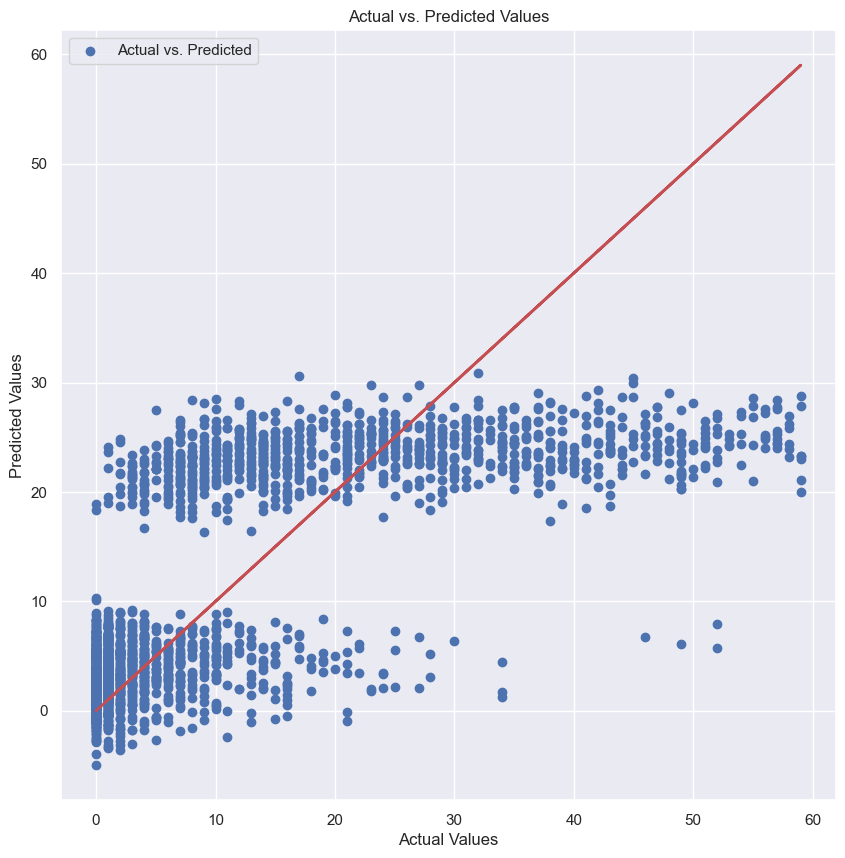

In [118]:
model_linear, y_pred_linear = make_linear_regression(X_train, y_train, X_val, y_val, "LinearRegression", {})
graph_for_model(y_val, y_pred_linear)

Mean Absolute Error: 5.522
Mean Squared Error: 72.544


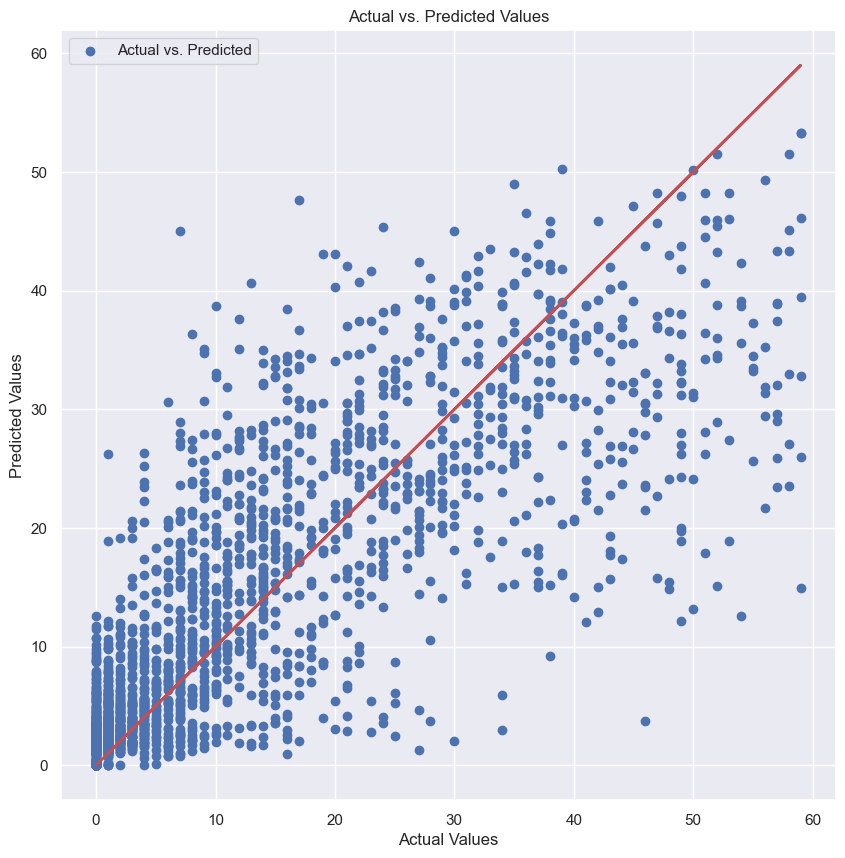

In [119]:
model_random_forest, y_pred_random_forest = make_linear_regression(X_train, y_train, X_val, y_val, "RandomForestRegressor", {})
graph_for_model(y_val, y_pred_random_forest)

Mean Absolute Error: 10.097
Mean Squared Error: 235.875


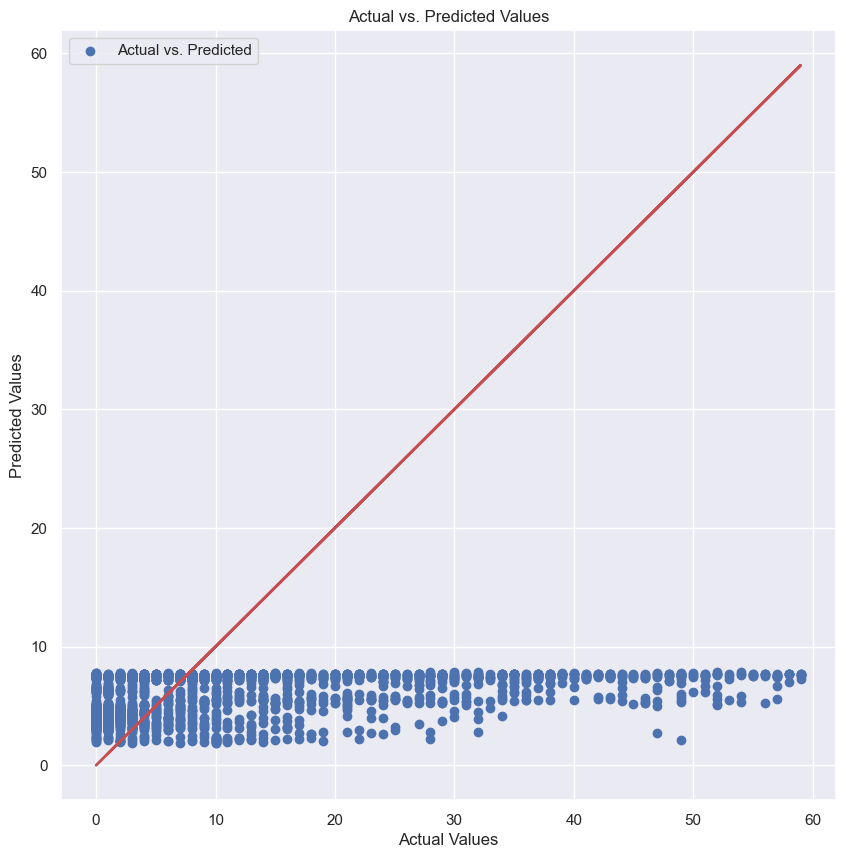

In [120]:
model_svr, y_pred_svr = make_linear_regression(X_train, y_train, X_val, y_val, "SVR", {})
graph_for_model(y_val, y_pred_svr)

Mean Absolute Error: 7.0
Mean Squared Error: 114.755


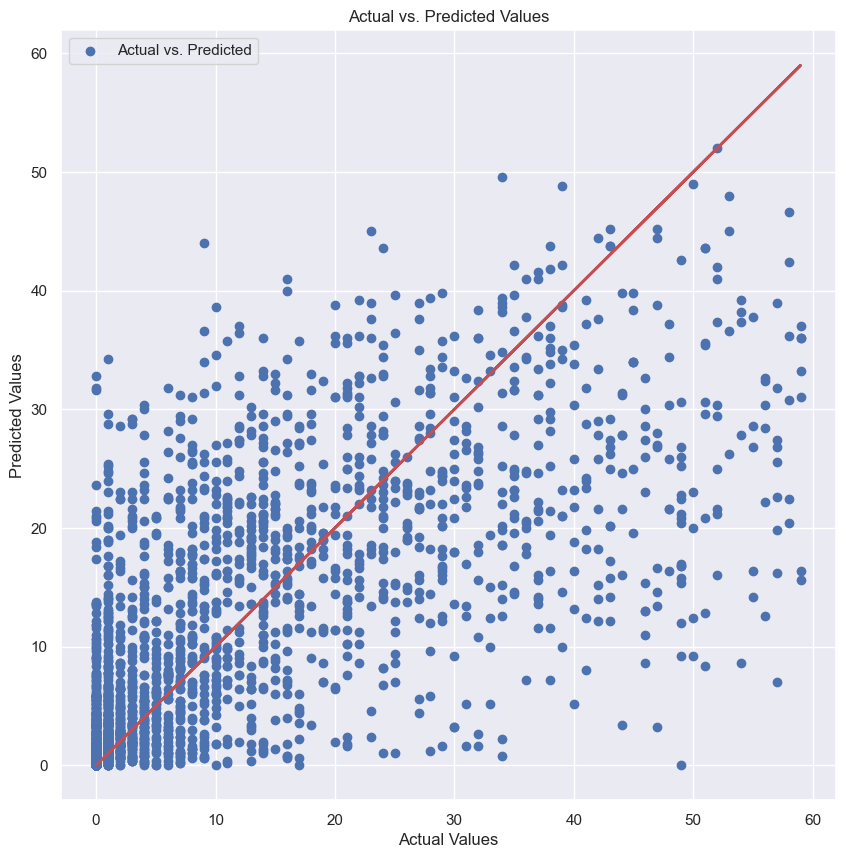

In [121]:
model_nn, y_pred_nn = make_linear_regression(X_train, y_train, X_val, y_val, "KNeighborsRegressor", {"n_neighbors": 5})
graph_for_model(y_val, y_pred_nn)

## NN

## Method for params for first nn

In [122]:
def set_params_for_neural_network():
    return {
        'units_layer1': 128,
        'units_layer2': 64,
        'units_layer3': 32,
        'units_layer4': 16,
        'units_layer5': 8,
        'units_layer6': 4,
        'activation': 'relu',
        'activation2': 'relu',
        'activation3': 'relu',
        'activation4': 'relu',
        'activation5': 'relu',
        'activation6': 'relu',
        'kernel_initializer': 'normal',
        'kernel_initializer2': 'normal',
        'kernel_initializer3': 'normal',
        'kernel_initializer4': 'normal',
        'kernel_initializer5': 'normal',
        'kernel_initializer6': 'normal'
    }

## Method for comparing graphs of train/val metrics

In [123]:
def history_graph_nn(history, final_epochs):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, final_epochs + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['mae'], label='Training MAE')
    plt.plot(epochs_range, history.history['val_mae'], label='Validation MAE')
    plt.legend(loc='upper right')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')

    plt.show()

In [124]:
def create_neural_network(X_train, y_train, X_val, y_val, params, name):
    units_layer1 = params['units_layer1']
    units_layer2 = params['units_layer2']
    units_layer3 = params['units_layer3']
    units_layer4 = params['units_layer4']
    units_layer5 = params['units_layer5']
    units_layer6 = params['units_layer6']
    activation = params['activation']
    activation2 = params['activation2']
    activation3 = params['activation3']
    activation4 = params['activation4']
    activation5 = params['activation5']
    activation6 = params['activation6']
    kernel_initializer = params['kernel_initializer']
    kernel_initializer2 = params['kernel_initializer2']
    kernel_initializer3 = params['kernel_initializer3']
    kernel_initializer4 = params['kernel_initializer4']
    kernel_initializer5 = params['kernel_initializer5']
    kernel_initializer6 = params['kernel_initializer6']

    model = tf.keras.models.Sequential([
            Dense(units_layer1, activation=activation, kernel_initializer=kernel_initializer, input_shape=(X_train.shape[1],)),
            Dense(units_layer2, activation=activation2, kernel_initializer=kernel_initializer2),
            Dense(units_layer3, activation=activation3, kernel_initializer=kernel_initializer3),
            Dense(units_layer4, activation=activation4, kernel_initializer=kernel_initializer4),
            Dense(units_layer5, activation=activation5, kernel_initializer=kernel_initializer5),
            Dense(units_layer6, activation=activation6, kernel_initializer=kernel_initializer6),
            Dense(1)
        ])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    model.compile(optimizer='nadam', loss = 'mse', metrics=['mae'])

    history = model.fit(X_train, 
                        y_train, 
                        epochs=100, 
                        batch_size=128, 
                        verbose=0, 
                        validation_data=(X_val, y_val), 
                        callbacks=[early_stopping])

    loss, mae = model.evaluate(X_val, y_val, verbose=0)

    metrics = model.metrics_names

    print(metrics[0], ":", Decimal(str(round(loss, 3))))
    print(metrics[1], ":", Decimal(str(round(mae, 3))))

    save_result_metrics(mae, loss, name, model)
    final_epochs = len(history.epoch)
    history_graph_nn(history, final_epochs)

    return model, history





loss : 98.015
mae : 6.829


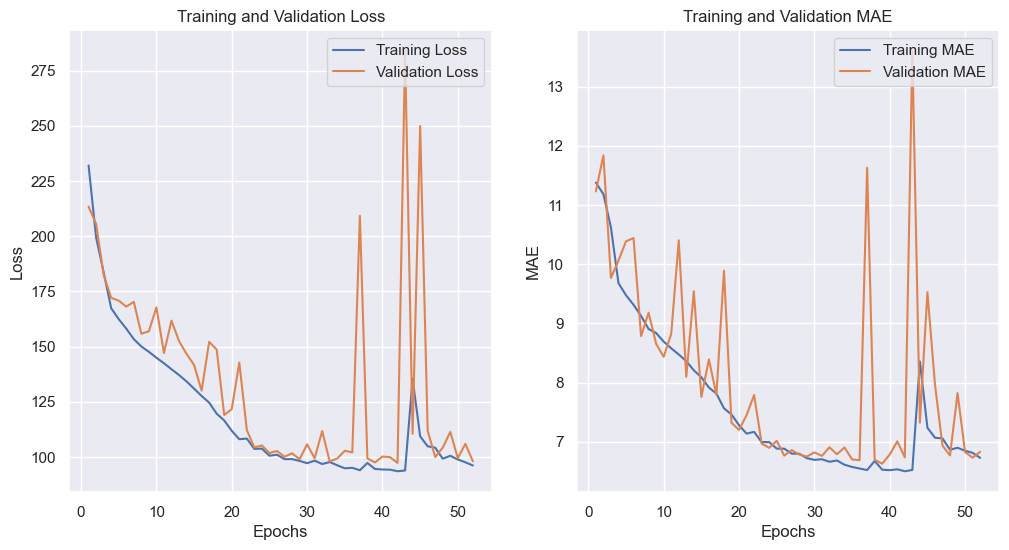

In [125]:
y_train = y_train.astype(float)
y_val = y_val.astype(float)

model_nn_selected, history_nn_selected = create_neural_network(X_train,
                                                                y_train,
                                                                X_val,
                                                                y_val,
                                                                set_params_for_neural_network(),
                                                                name="Neural Network")

## Adding regularizer, changing other values

loss : 115.732
mae : 7.118


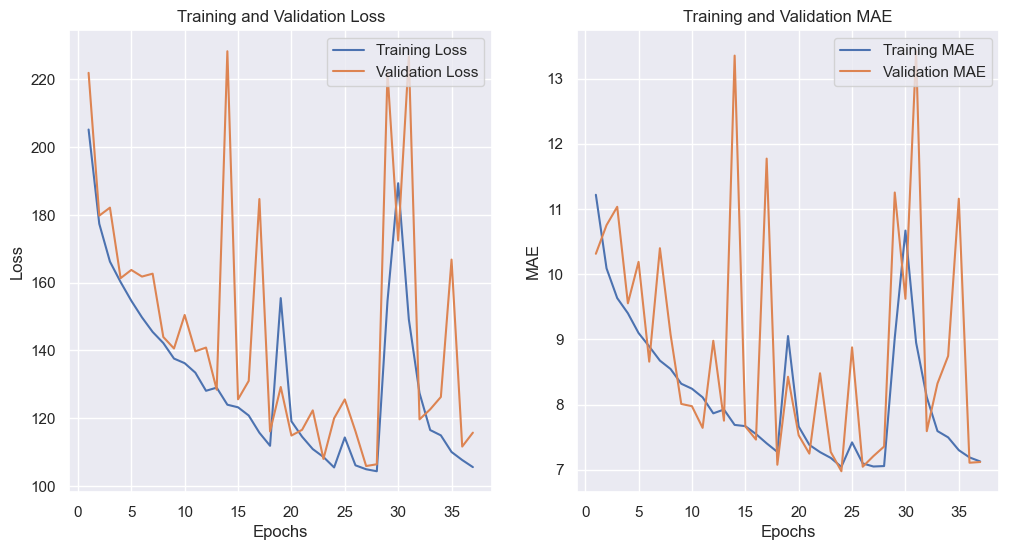

In [126]:
model_0 = tf.keras.models.Sequential([
            Dense(256, activation='relu', kernel_initializer='normal', input_shape=(X_train.shape[1],)),
            Dense(128, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(0.01)),
            Dense(64, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(0.01)),
            Dense(32, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(0.01)),
            Dense(16, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(0.01)),                   
            Dense(1)
        ])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model_0.compile(optimizer='nadam', loss = 'mse', metrics=['mae'])

history = model_0.fit(X_train, 
                        y_train, 
                        epochs=200, 
                        batch_size=128, 
                        verbose=0, 
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

loss, mae = model_0.evaluate(X_val, y_val, verbose=0)

metrics = model_0.metrics_names

print(metrics[0], ":", Decimal(str(round(loss, 3))))
print(metrics[1], ":", Decimal(str(round(mae, 3))))

save_result_metrics(mae, loss, "Neural Network with Regularization", model_0)
final_epochs = len(history.epoch)
history_graph_nn(history, final_epochs)

loss : 116.208
mae : 6.795


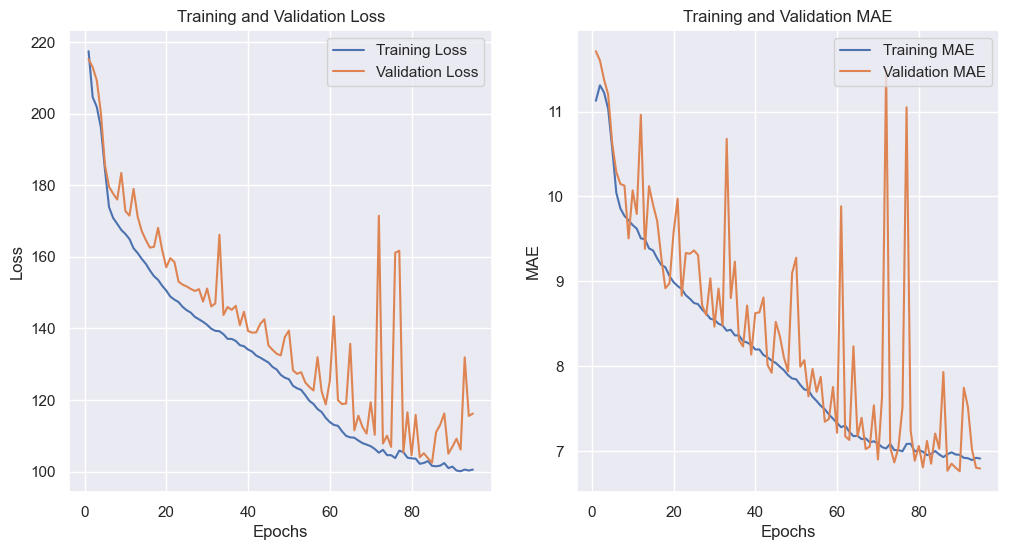

In [127]:
model_1 = Sequential([
            Dense(256, activation='relu', kernel_initializer='normal', input_shape=(X_train.shape[1],)),
            Dense(128, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(0.01)),
            Dense(64, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(0.01)),
            Dense(32, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(0.01)),
            Dense(16, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(0.01)),                   
            Dense(1)
        ])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
learning_rate = 0.0001

optimizer_value = Nadam(learning_rate=learning_rate)

model_1.compile(optimizer=optimizer_value, loss = 'mse', metrics=['mae'])

history = model_1.fit(X_train, 
                        y_train, 
                        epochs=200, 
                        batch_size=128, 
                        verbose=0, 
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

loss, mae = model_1.evaluate(X_val, y_val, verbose=0)

metrics = model_1.metrics_names

print(metrics[0], ":", Decimal(str(round(loss, 3))))
print(metrics[1], ":", Decimal(str(round(mae, 3))))

save_result_metrics(mae, loss, "Neural Network with learning rate", model_1)
final_epochs = len(history.epoch)
history_graph_nn(history, final_epochs)

In [128]:
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

Y_TRAIN = Y_TRAIN.astype(np.float32)
Y_VAL = Y_VAL.astype(np.float32)

In [129]:
def train_model(config):
    global X_TRAIN, Y_TRAIN, X_VAL, Y_VAL

    epochs = 200

    model = Sequential()

    for _ in range(config["layers"]):
        model.add(Dense(config["hidden"], 
                                        activation=config["activation"],
                                        kernel_regularizer=config["kernel_regularizer"],
                                        kernel_initializer=config["kernel_initializer"]))
        model.add(Dropout(config["dropout"]))

    model.add(tf.keras.layers.Dense(1))

    if config["optimizer"] == "adam":
        optimizer = Adam(learning_rate=config["learning_rate"])
    elif config["optimizer"] == "sgd":
        optimizer = SGD(learning_rate=config["learning_rate"])
    elif config["optimizer"] == "nadam":
        optimizer = Nadam(learning_rate=config["learning_rate"])
    elif config["optimizer"] == "rmsprop":
        optimizer = RMSprop(learning_rate=config["learning_rate"])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=["mae"],
    )

    model.fit(
        X_TRAIN,
        Y_TRAIN,
        batch_size=config["batch_size"],
        epochs=epochs,
        verbose=0,
        validation_data=(X_VAL, Y_VAL),
        callbacks=[early_stopping, ReportCheckpointCallback(metrics=["loss", "mae"])],
    )

    with mlflow.start_run():
        mlflow_save_metrics(config, model)

def mlflow_save_metrics(config, model):
    for key, value in config.items():
        mlflow.log_param(key, value)

    mlflow.log_metric("loss", model.history.history["loss"][-1])
    mlflow.log_metric("val_loss", model.history.history["val_loss"][-1])
    mlflow.log_metric("mae", model.history.history["mae"][-1])
    mlflow.log_metric("val_mae", model.history.history["val_mae"][-1])

In [130]:
def tune_model_ray_tune():
    sched = AsyncHyperBandScheduler(
        time_attr="training_iteration"
    )

    tuner = tune.Tuner(
        train_model,
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=sched,
            num_samples=100,
        ),
        run_config=train.RunConfig(
            name="trial",            
            verbose=0,
            callbacks=[MLflowLoggerCallback(
                    tracking_uri="http://localhost:5000",
                    experiment_name="shelter",
                    save_artifact=True,
                )]
        ),
        param_space={
            "threads": 2,
            "batch_size": tune.choice([32, 64, 128, 256]),
            "learning_rate": tune.uniform(0.001, 0.1),
            "hidden": tune.randint(32, 512),
            "layers": tune.randint(1, 10),
            "dropout": tune.uniform(0.0, 0.5),
            "optimizer": tune.choice(["adam", "sgd", "nadam", "rmsprop"]),
            "activation": tune.choice(["relu", "sigmoid", "softplus"]),
            "kernel_initializer": tune.choice(["normal", "uniform"]),
            "kernel_regularizer": tune.choice([None, "l1", "l2", "l1_l2"]),
        },
    )
    results = tuner.fit()

    print(results.get_best_result())

    print("Best hyperparameters found were: ", results.get_best_result().config)

    return results

In [131]:
def read_credentials():
    with open("credentials.txt", "r") as file:
        credentials = file.read().splitlines()
    return credentials

def remove_files_and_folders(folder_path):
    items = os.listdir(folder_path)

    for item in items:
        item_path = os.path.join(folder_path, item)
        try:
            if os.path.isfile(item_path):
                os.remove(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        except Exception as e:
            print(f"Error: {e}")

folder_path = read_credentials()[0]
remove_files_and_folders(folder_path)

In [132]:
#!mlflow server --host 127.0.0.1 --port 5000

In [133]:
ray.init(logging_level=logging.ERROR)
results = tune_model_ray_tune()

(pid=31532) 2024-04-25 23:13:09.420826: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=31532) WARNING:tensorflow:From c:\Users\CEM\Desktop\All\PJATK\MAGISTERKA\magisterka_repo\shelter\.venv\lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.
(pid=31532) 
(pid=28340) 2024-04-25 23:13:13.656285: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to dis

Result(
  metrics={'loss': 110.81897735595703, 'mae': 7.241448402404785},
  path='C:/Users/CEM/ray_results/trial/train_model_90fa8_00056_56_activation=sigmoid,batch_size=32,dropout=0.0751,hidden=249,kernel_initializer=normal,kernel_regularizer_2024-04-25_23-23-24',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=C:/Users/CEM/ray_results/trial/train_model_90fa8_00056_56_activation=sigmoid,batch_size=32,dropout=0.0751,hidden=249,kernel_initializer=normal,kernel_regularizer_2024-04-25_23-23-24/checkpoint_000057)
)
Best hyperparameters found were:  {'threads': 2, 'batch_size': 32, 'learning_rate': 0.0010841807600505315, 'hidden': 249, 'layers': 3, 'dropout': 0.07514230959927187, 'optimizer': 'nadam', 'activation': 'sigmoid', 'kernel_initializer': 'normal', 'kernel_regularizer': 'l2'}


In [134]:
the_best_model_path = f"{results.get_best_result().checkpoint.path}/model.keras"
loaded_model = load_model(the_best_model_path)
loss, mae = loaded_model.evaluate(X_val, y_val, verbose=0)
save_result_metrics(mae, loss, "Optimized Neural Network", loaded_model)

In [135]:
print_results()

,Model name,MAE,LOSS (mse),MODEL_OBJECT
0,RandomForestRegressor,5.522000,72.544000,"(DecisionTreeRegressor(max_features=1.0, rando..."
1,Neural Network with learning rate,6.794533,116.207993,<keras.src.engine.sequential.Sequential object...
2,Neural Network,6.829428,98.015068,<keras.src.engine.sequential.Sequential object...
3,KNeighborsRegressor,7.000000,114.755000,KNeighborsRegressor()
4,Neural Network with Regularization,7.118234,115.731697,<keras.src.engine.sequential.Sequential object...
5,LinearRegression,7.238000,105.016000,LinearRegression()
6,Optimized Neural Network,7.277121,106.570267,<keras.src.engine.sequential.Sequential object...
7,SVR,10.097000,235.875000,SVR()


In [136]:
def get_pipeline():
    return Pipeline([('regressor', RandomForestRegressor())])

def grid_search(X_train, y_train, X_val, y_val):
    pipe = get_pipeline()

    param_grid = {
        'regressor__n_estimators': [100, 200, 300, 400, 500],
        'regressor__max_features': ['sqrt', 'log2'],
        'regressor__max_depth' : [4,5,6,7,8],
        'regressor__criterion' :['absolute_error', 'squared_error']
        }

    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    print(grid.best_score_)
    print(grid.best_estimator_)

    y_pred = grid.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)

    rounded_mae = round(mae, 3)
    rounded_mse = round(mse, 3)

    print("Mean Absolute Error:", Decimal(str(rounded_mae)))
    print("Mean Squared Error:", Decimal(str(rounded_mse)))

    save_result_metrics(rounded_mae, rounded_mse, "Grid Search", grid)

    return grid

grid = grid_search(X_train, y_train, X_val, y_val)

{'regressor__criterion': 'squared_error', 'regressor__max_depth': 8, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 500}
0.6174753882880621
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=8, max_features='sqrt',
                                       n_estimators=500))])
Mean Absolute Error: 6.094
Mean Squared Error: 79.88


In [137]:
best_model = RESULTS[min(RESULTS, key=lambda x: RESULTS[x]['MAE'])]["MODEL_OBJECT"]

## Manual predicition on the best model on test values

In [138]:
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

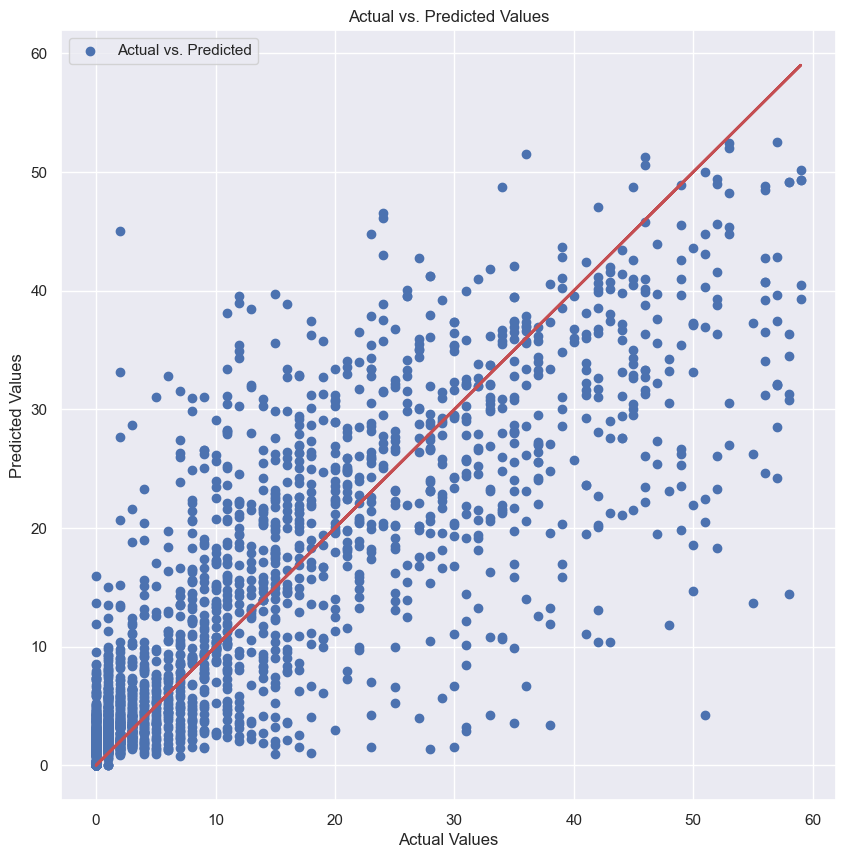

In [139]:
y_pred = best_model.predict(X_test)

def graph_for_model(y_test, y_pred, lim=None):
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred, c='b', marker='o', label='Actual vs. Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.plot(y_test, y_test, 'r-', linewidth=2)
    if lim:
        plt.xlim(0, lim)
        plt.ylim(0, lim)
    plt.show()

graph_for_model(y_test, y_pred)

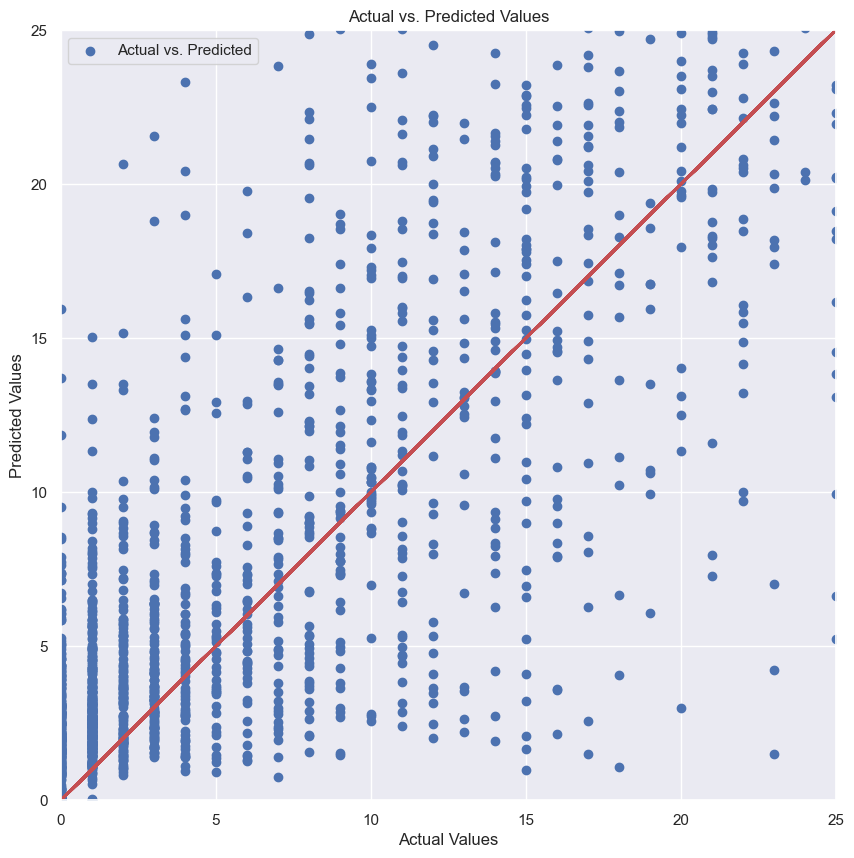

In [140]:
graph_for_model(y_test, y_pred, 25)

In [141]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Loss:", mse)
print("MAE:", mae)

Loss: 65.96482721629033
MAE: 5.141022497043522


In [142]:
final_results = print_results()

In [143]:
final_results.to_csv("files_for_analysis/final_results.csv")

In [144]:
ray.shutdown()